In [42]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [76]:
class person:
    def __init__(self,i,gender, orientation, age, sexual_activity):
        # gender 0 : male, 1 : female
        # orientation 0 : straight, 1 : homosexual
        # time_since_infection equals -1 if not infected
        
        self.identifier = i
        self.sec_id = -1
        self.gender = gender
        self.orientation = orientation
        self.age = age
        self.sexual_activity = sexual_activity
        self.disease_status = 0
        self.time_since_infection = -1
        self.number_of_partners = 0
        self.current_partners = set()
    
    def print_state(self):
        print(self.identifier, 
              self.gender, 
              self.orientation,
              self.age,
              self.sexual_activity,
              self.disease_status,
              self.time_since_infection,
              self.number_of_partners,
              self.current_partners)
    
    def add_partner(self, other_person,s):
        if self.number_of_partners == 0:
            s.number_of_singles -= 1
        if other_person.identifier not in self.current_partners:
            self.number_of_partners += 1
            self.current_partners.add(other_person.identifier)
        
    def remove_partner(self, other_person,s):
        self.number_of_partners -= 1
        self.current_partners.remove(other_person.identifier)
        
        if self.number_of_partners == 0:
            s.number_of_singles += 1
    
    def asymptomatic_infection(self, s):
        self.disease_status = 2
        self.time_since_infection = 0
        s.number_of_asymptomatic += 1
        
    def symptomatic_infection(self, s):
        self.disease_status = 1
        self.time_since_infection = 0
        s.number_of_symptomatic += 1
    
    def cure(self, s):
        if self.disease_status == 1:
            s.number_of_symptomatic -= 1
        elif self.disease_status == 2:
            s.number_of_asymptomatic -= 1
        self.disease_status = 0
        self.time_since_infection = -1
        
class Partnership:
    def __init__(self,partnership_type,person1,person2):
        """
        type 1 : steady, 2 : casual
        
        """
        self.type = partnership_type
        self.persons = [person1,person2]
    
    def print_state(self):
        print(self.type,
              self.persons[0].identifier,
              self.persons[1].identifier)
        
class system:
    def __init__(self):
        self.persons = []
        self.partnerships = []
        self.straight_males = []
        self.homosexual_males = []
        self.females = []
        self.time = 0
        self.number_of_symptomatic = 0
        self.number_of_asymptomatic = 0
        self.number_of_steady = 0
    
    def set_constants(self,
                      f = 0.2,
                      rho = 0.006,
                      sigma1 = 0.0004,
                      sigma2 = 0.1,
                      transmission_male_female_steady = 0.15,
                      transmission_female_male_steady = 0.0625,
                      transmission_male_female_casual = 0.6,
                      transmission_female_male_casual = 0.25,
                      asymptomatic_men = 0.1,
                      asymptomatic_women = 0.45,
                      incubation_time_men = 5,
                      incubation_time_women = 10,
                      patient_delay_treatment_men = 5,
                      patient_delay_treatment_women = 8,
                      recovery_rate_asymptomatic_men = 0.0074,
                      recovery_rate_symptomatic_men = 0.04,
                      recovery_rate_asymptomatic_women = 0.0044,
                      recovery_rate_symptomatic_women = 0.03,
                      screening_percentage = 0.02):
        """
        sets constants

        Definitions
        f: probability of steady partnership
        rho: probability of forming partnership
        sigma1 : probability of steady partnership separation
        sigma2 : probability of casual partnership separation
        """
        self.f = f
        self.rho = rho
        self.sigma1 = sigma1
        self.sigma2 = sigma2

        self.transmission_male_female_steady = transmission_male_female_steady
        self.transmission_female_male_steady = transmission_female_male_steady
        self.transmission_male_female_casual = transmission_male_female_casual
        self.transmission_female_male_casual = transmission_female_male_casual
        self.asymptomatic_men = asymptomatic_men
        self.asymptomatic_women = asymptomatic_women
        self.incubation_time_men = incubation_time_men
        self.incubation_time_women = incubation_time_women
        self.patient_delay_treatment_men = patient_delay_treatment_men
        self.patient_delay_treatment_women = patient_delay_treatment_women
        self.recovery_rate_asymptomatic_men = recovery_rate_asymptomatic_men
        self.recovery_rate_symptomatic_men = recovery_rate_symptomatic_men
        self.recovery_rate_asymptomatic_women = recovery_rate_asymptomatic_women
        self.recovery_rate_symptomatic_men = recovery_rate_symptomatic_men
        self.screening_percentage = screening_percentage

    
    def initialize(self,number_of_persons, gender_ratio, queer_ratio):
        for i in range(number_of_persons):
            gender =  0 if np.random.random() > gender_ratio else 1
            orientation = 1 if gender == 0 and np.random.random() < queer_ratio else 0
            age = np.random.randint(15,65)
            if age >= 15 and age < 35:
                sexual_activity = 1 if np.random.random() < 0.05 else 0
            else:
                sexual_activity = 0
            
            
            p = person(i,gender, orientation, age, sexual_activity)
            self.persons.append(p)
            if gender == 0 and orientation == 0:
                p.sec_id = len(self.straight_males)
                self.straight_males.append(p)
            elif gender == 0 and orientation == 1:
                p.sec_id = len(self.homosexual_males)
                self.homosexual_males.append(p)
            else:
                p.sec_id = len(self.females)
                self.females.append(p)
        self.number_of_singles = number_of_persons
    
    def replace_person(self,p):
        identifier = p.identifier
        sec_id = p.sec_id
        gender = p.gender
        orientation = p.orientation
        age = 15
        sexual_activity = 1 if np.random.random() < 0.05 else 0
    
        #remove p from current partners from all p's current partners
        for j in p.current_partners:
            o = self.persons[j]
            o.remove_partner(p,self)
        
        #update system numbers
        if p.number_of_partners > 0:
            self.number_of_singles += 1
        p.cure(self)
        
        #remove partnerships where p is involved in
        for i,ps in enumerate(self.partnerships):
            if p.identifier in [ps.persons[0].identifier,ps.persons[1].identifier]:
                #deleting steady partnership
                if ps.type == 1:
                    self.number_of_steady -= 1
                self.partnerships[i] = None
                
        self.partnerships = list(filter(None,self.partnerships))
            
        new_person = person(identifier,gender, orientation, age, sexual_activity)
        new_person.sec_id = sec_id
        
        #update lists of persons
        self.persons[identifier] = new_person
        if gender == 0 and orientation == 0:
            self.straight_males[sec_id] = new_person
        elif gender == 0 and orientation == 1:
            self.homosexual_males[sec_id] = new_person
        elif gender == 1:
            self.females[sec_id] = new_person
    
    def print_state(self):
        print("id\tgender\torientation\tage\tactivity\tdisease\ttime since inf\t#partners\tcurrent partners")
        for p in self.persons:
            p.print_state()
        print("type\tpersons")
        for ps in self.partnerships:
            ps.print_state()
            
    def time_step(self):
        n = int(len(self.persons)/2) - len(self.partnerships)
        
        #creation of partnerships
        for i in range(n):
            if np.random.random() < self.rho:
                formed = False
                partnership_type = 1 if np.random.random() < self.f else 2
                
                #add a end condition
                iteration = 0
                while(not formed and iteration < 100):
                    #form partnership
                    y = np.random.choice(self.straight_males)
                    x = np.random.choice(self.females)
                    
                    exists = False
                    mixing_prob = mixing_probability(x,y,partnership_type)
                    if np.random.random() < mixing_prob:
                        for ps in self.partnerships:
                            if y in ps.persons and x in ps.persons:
                                exists = True
                        if not exists:
                            p = Partnership(partnership_type,x,y)
                            x.add_partner(y,self)
                            y.add_partner(x,self)
                            self.partnerships.append(p)
                            formed = True
                            
                            if partnership_type == 1:
                                self.number_of_steady += 1
                    iteration += 1
        
        #TODO: Disease transmission
        for i,partnership in enumerate(self.partnerships):
            p1, p2 = partnership.persons
            s1 = p1.disease_status
            s2 = p2.disease_status
            partnership_type = partnership.type
            
            if s1 > 0 and s2 == 0:
                infected = p1
                non_infected = p2
            elif s1 == 0 and s2 > 0:
                infected = p2
                non_infected = p1
            else:
                continue
            
            #extend with MSM
                
                
            if infected.gender == 0 and non_infected.gender == 1:
                if partnership_type == 1:
                    if np.random.random() < self.transmission_male_female_steady:
                        if np.random.random() < self.asymptomatic_women:
                            non_infected.asymptomatic_infection(self)
                        else:
                            non_infected.symptomatic_infection(self)
                elif partnership_type == 2:
                    if np.random.random() < self.transmission_male_female_casual:
                        if np.random.random() < self.asymptomatic_women:
                            non_infected.asymptomatic_infection(self)
                        else:
                            non_infected.symptomatic_infection(self)
            elif infected.gender == 1 and non_infected.gender == 0:
                if partnership_type == 1:
                    if np.random.random() < self.transmission_female_male_steady:
                        if np.random.random() < self.asymptomatic_men:
                            non_infected.asymptomatic_infection(self)
                        else:
                            non_infected.symptomatic_infection(self)
                elif partnership_type == 2:
                    if np.random.random() < self.transmission_female_male_casual:
                        if np.random.random() < self.asymptomatic_men:
                            non_infected.asymptomatic_infection(self)
                        else:
                            non_infected.symptomatic_infection(self)
        
        #Separation of partnerships
        for i,ps in enumerate(self.partnerships):
            partnership_type = ps.type
            p1, p2 = ps.persons
            
            #TODO: check type
            if partnership_type == 1:
                if np.random.random() < self.sigma1:
                    p1.remove_partner(p2,self)
                    p2.remove_partner(p1,self)
                    self.partnerships[i] = None
                    self.number_of_steady -= 1
            elif partnership_type == 2:
                if np.random.random() < self.sigma2:
                    p1.remove_partner(p2,self)
                    p2.remove_partner(p1,self)
                    self.partnerships[i] = None
        self.partnerships = list(filter(None,self.partnerships))
        
        #Replacement
        for p in self.persons:
            if p.age >= 64:
                #replace with new person
                self.replace_person(p)
        
        
        #TODO: Recovery
        for p in self.persons:
            if p.gender == 0 and p.disease_status == 1:
                if np.random.random() < self.recovery_rate_symptomatic_men:
                    p.cure(self)
            elif p.gender == 0 and p.disease_status == 2:
                if np.random.random() < self.recovery_rate_asymptomatic_men:
                    p.cure(self)
            elif p.gender == 1 and p.disease_status == 1:
                if np.random.random() < self.recovery_rate_symptomatic_women:
                    p.cure(self)
            elif p.gender == 1 and p.disease_status == 2:
                if np.random.random() < self.recovery_rate_asymptomatic_women:
                    p.cure(self)
                
        #Treatment
        for p in self.persons:
            if p.disease_status == 1:
                if p.gender == 0:
                    if p.time_since_infection >= self.incubation_time_men + self.patient_delay_treatment_men:
                        p.cure(self)
                        for j in p.current_partners:
                            o = self.persons[j]
                            o.cure(self)
                elif p.gender == 1:
                    if p.time_since_infection >= self.incubation_time_women + self.patient_delay_treatment_women:
                        p.cure(self)
                        for j in p.current_partners:
                            o = self.persons[j]
                            o.cure(self)
        
        #Screening
        if self.time % 365 == 0:
            number = int(len(self.persons)*self.screening_percentage)
            screened = np.random.choice(self.persons,number)
            for p in screened:
                p.cure(self)
        
        #Increase time
        self.time += 1
        for p in self.persons:
            if p.disease_status > 0:
                p.time_since_infection += 1
        
        if self.time % 365 == 0:
            for i,p in enumerate(self.persons):
                p.age += 1
        

def mixing_probability(x,y,partnership_type):
    j = age_group(x)
    k = age_group(y)
    
    if j == k:
        phi_a = 1
    else:
        phi_a = 0.2**(np.abs(j + 1 - k))
    
    # c = sexual_activity
    # d = number_of_partners
    
    if partnership_type == 1:
        if x.number_of_partners == 0 and y.number_of_partners == 0:
            phi_cd = 1
        else:
            phi_cd = 0
    else:
        if x.sexual_activity == 1 and y.sexual_activity == 1:
            phi_cd = 1
        elif x.sexual_activity == 1 and y.sexual_activity == 0\
        and y.number_of_partners == 0:
            phi_cd = 0.1
        elif y.sexual_activity == 1 and x.sexual_activity == 0\
        and x.number_of_partners == 0:
            phi_cd = 0.1
        elif x.sexual_activity == 0 and x.number_of_partners == 0\
        and y.sexual_activity == 0 and y.number_of_partners == 0:
            phi_cd = 0.01
        else:
            phi_cd = 0
    return phi_a * phi_cd
        
    
    
def age_group(p):
    a = p.age
    if a >= 15 and a < 25:
        age_group = 1
    elif a >= 25 and a < 35:
        age_group = 2
    elif a >= 35 and a < 45:
        age_group = 3
    elif a >= 45 and a < 55:
        age_group = 4
    else:
        age_group = 5
    return age_group
        
        
        
        
        

            

In [77]:
s = system()
s.initialize(10000,0.5,0)
s.set_constants()
# for i in range(10000):
#     s.time_step()
s.time = 0


In [78]:
s.print_state()

id	gender	orientation	age	activity	disease	time since inf	#partners	current partners
0 1 0 47 0 0 -1 0 set()
1 0 0 58 0 0 -1 0 set()
2 0 0 55 0 0 -1 0 set()
3 0 0 47 0 0 -1 0 set()
4 0 0 45 0 0 -1 0 set()
5 1 0 61 0 0 -1 0 set()
6 0 0 22 0 0 -1 0 set()
7 0 0 55 0 0 -1 0 set()
8 1 0 21 0 0 -1 0 set()
9 0 0 56 0 0 -1 0 set()
10 0 0 50 0 0 -1 0 set()
11 0 0 34 0 0 -1 0 set()
12 1 0 23 0 0 -1 0 set()
13 1 0 18 0 0 -1 0 set()
14 1 0 34 0 0 -1 0 set()
15 1 0 64 0 0 -1 0 set()
16 1 0 58 0 0 -1 0 set()
17 1 0 31 0 0 -1 0 set()
18 0 0 58 0 0 -1 0 set()
19 1 0 16 0 0 -1 0 set()
20 1 0 36 0 0 -1 0 set()
21 0 0 25 0 0 -1 0 set()
22 0 0 31 0 0 -1 0 set()
23 1 0 64 0 0 -1 0 set()
24 1 0 64 0 0 -1 0 set()
25 1 0 62 0 0 -1 0 set()
26 1 0 19 0 0 -1 0 set()
27 1 0 43 0 0 -1 0 set()
28 0 0 34 0 0 -1 0 set()
29 0 0 46 0 0 -1 0 set()
30 1 0 56 0 0 -1 0 set()
31 1 0 35 0 0 -1 0 set()
32 1 0 60 0 0 -1 0 set()
33 1 0 44 0 0 -1 0 set()
34 0 0 54 0 0 -1 0 set()
35 1 0 17 0 0 -1 0 set()
36 0 0 54 0 0 -1 0 set()


339 0 0 48 0 0 -1 0 set()
340 1 0 30 0 0 -1 0 set()
341 1 0 54 0 0 -1 0 set()
342 0 0 30 0 0 -1 0 set()
343 1 0 58 0 0 -1 0 set()
344 1 0 43 0 0 -1 0 set()
345 0 0 38 0 0 -1 0 set()
346 1 0 54 0 0 -1 0 set()
347 1 0 52 0 0 -1 0 set()
348 0 0 37 0 0 -1 0 set()
349 0 0 42 0 0 -1 0 set()
350 1 0 16 0 0 -1 0 set()
351 0 0 36 0 0 -1 0 set()
352 1 0 63 0 0 -1 0 set()
353 1 0 55 0 0 -1 0 set()
354 0 0 35 0 0 -1 0 set()
355 0 0 53 0 0 -1 0 set()
356 1 0 29 0 0 -1 0 set()
357 0 0 16 0 0 -1 0 set()
358 0 0 37 0 0 -1 0 set()
359 0 0 64 0 0 -1 0 set()
360 0 0 51 0 0 -1 0 set()
361 1 0 39 0 0 -1 0 set()
362 0 0 45 0 0 -1 0 set()
363 0 0 20 0 0 -1 0 set()
364 0 0 48 0 0 -1 0 set()
365 1 0 63 0 0 -1 0 set()
366 0 0 17 0 0 -1 0 set()
367 0 0 23 0 0 -1 0 set()
368 0 0 59 0 0 -1 0 set()
369 0 0 55 0 0 -1 0 set()
370 0 0 44 0 0 -1 0 set()
371 1 0 39 0 0 -1 0 set()
372 1 0 30 0 0 -1 0 set()
373 0 0 15 0 0 -1 0 set()
374 0 0 49 0 0 -1 0 set()
375 1 0 23 0 0 -1 0 set()
376 0 0 57 0 0 -1 0 set()
377 1 0 63 0

790 0 0 32 0 0 -1 0 set()
791 0 0 20 0 0 -1 0 set()
792 0 0 63 0 0 -1 0 set()
793 0 0 43 0 0 -1 0 set()
794 1 0 15 0 0 -1 0 set()
795 1 0 36 0 0 -1 0 set()
796 0 0 20 0 0 -1 0 set()
797 0 0 49 0 0 -1 0 set()
798 1 0 58 0 0 -1 0 set()
799 0 0 20 0 0 -1 0 set()
800 1 0 18 1 0 -1 0 set()
801 1 0 36 0 0 -1 0 set()
802 1 0 60 0 0 -1 0 set()
803 0 0 42 0 0 -1 0 set()
804 0 0 16 0 0 -1 0 set()
805 1 0 30 0 0 -1 0 set()
806 0 0 35 0 0 -1 0 set()
807 0 0 28 0 0 -1 0 set()
808 1 0 60 0 0 -1 0 set()
809 1 0 44 0 0 -1 0 set()
810 1 0 29 0 0 -1 0 set()
811 0 0 23 0 0 -1 0 set()
812 0 0 15 0 0 -1 0 set()
813 0 0 45 0 0 -1 0 set()
814 0 0 42 0 0 -1 0 set()
815 1 0 48 0 0 -1 0 set()
816 1 0 44 0 0 -1 0 set()
817 0 0 56 0 0 -1 0 set()
818 0 0 42 0 0 -1 0 set()
819 0 0 16 0 0 -1 0 set()
820 1 0 59 0 0 -1 0 set()
821 1 0 21 0 0 -1 0 set()
822 1 0 62 0 0 -1 0 set()
823 0 0 61 0 0 -1 0 set()
824 0 0 29 0 0 -1 0 set()
825 1 0 56 0 0 -1 0 set()
826 0 0 60 0 0 -1 0 set()
827 1 0 17 0 0 -1 0 set()
828 1 0 28 0

1123 0 0 56 0 0 -1 0 set()
1124 0 0 30 0 0 -1 0 set()
1125 1 0 18 0 0 -1 0 set()
1126 1 0 25 0 0 -1 0 set()
1127 0 0 31 0 0 -1 0 set()
1128 0 0 54 0 0 -1 0 set()
1129 1 0 41 0 0 -1 0 set()
1130 1 0 21 0 0 -1 0 set()
1131 1 0 43 0 0 -1 0 set()
1132 0 0 29 0 0 -1 0 set()
1133 1 0 32 0 0 -1 0 set()
1134 1 0 29 0 0 -1 0 set()
1135 1 0 32 0 0 -1 0 set()
1136 1 0 26 1 0 -1 0 set()
1137 0 0 26 0 0 -1 0 set()
1138 1 0 53 0 0 -1 0 set()
1139 0 0 44 0 0 -1 0 set()
1140 1 0 33 0 0 -1 0 set()
1141 0 0 39 0 0 -1 0 set()
1142 1 0 19 0 0 -1 0 set()
1143 1 0 45 0 0 -1 0 set()
1144 0 0 47 0 0 -1 0 set()
1145 1 0 33 0 0 -1 0 set()
1146 1 0 62 0 0 -1 0 set()
1147 1 0 42 0 0 -1 0 set()
1148 0 0 34 0 0 -1 0 set()
1149 0 0 31 0 0 -1 0 set()
1150 1 0 51 0 0 -1 0 set()
1151 1 0 59 0 0 -1 0 set()
1152 1 0 64 0 0 -1 0 set()
1153 1 0 28 0 0 -1 0 set()
1154 1 0 53 0 0 -1 0 set()
1155 0 0 61 0 0 -1 0 set()
1156 1 0 25 0 0 -1 0 set()
1157 0 0 50 0 0 -1 0 set()
1158 1 0 34 0 0 -1 0 set()
1159 1 0 37 0 0 -1 0 set()
1

1457 0 0 24 0 0 -1 0 set()
1458 1 0 53 0 0 -1 0 set()
1459 1 0 42 0 0 -1 0 set()
1460 1 0 19 0 0 -1 0 set()
1461 1 0 41 0 0 -1 0 set()
1462 0 0 60 0 0 -1 0 set()
1463 1 0 55 0 0 -1 0 set()
1464 1 0 63 0 0 -1 0 set()
1465 1 0 63 0 0 -1 0 set()
1466 1 0 64 0 0 -1 0 set()
1467 1 0 41 0 0 -1 0 set()
1468 1 0 30 0 0 -1 0 set()
1469 0 0 43 0 0 -1 0 set()
1470 0 0 18 0 0 -1 0 set()
1471 0 0 36 0 0 -1 0 set()
1472 0 0 55 0 0 -1 0 set()
1473 1 0 41 0 0 -1 0 set()
1474 1 0 44 0 0 -1 0 set()
1475 1 0 35 0 0 -1 0 set()
1476 0 0 30 0 0 -1 0 set()
1477 0 0 49 0 0 -1 0 set()
1478 0 0 60 0 0 -1 0 set()
1479 0 0 48 0 0 -1 0 set()
1480 0 0 21 0 0 -1 0 set()
1481 0 0 32 0 0 -1 0 set()
1482 1 0 51 0 0 -1 0 set()
1483 0 0 56 0 0 -1 0 set()
1484 1 0 31 0 0 -1 0 set()
1485 0 0 36 0 0 -1 0 set()
1486 0 0 40 0 0 -1 0 set()
1487 1 0 35 0 0 -1 0 set()
1488 0 0 21 0 0 -1 0 set()
1489 0 0 57 0 0 -1 0 set()
1490 0 0 26 0 0 -1 0 set()
1491 1 0 52 0 0 -1 0 set()
1492 0 0 20 0 0 -1 0 set()
1493 0 0 45 0 0 -1 0 set()
1

1790 0 0 44 0 0 -1 0 set()
1791 0 0 40 0 0 -1 0 set()
1792 0 0 36 0 0 -1 0 set()
1793 0 0 49 0 0 -1 0 set()
1794 0 0 38 0 0 -1 0 set()
1795 0 0 57 0 0 -1 0 set()
1796 0 0 28 0 0 -1 0 set()
1797 1 0 63 0 0 -1 0 set()
1798 1 0 28 0 0 -1 0 set()
1799 1 0 43 0 0 -1 0 set()
1800 0 0 20 1 0 -1 0 set()
1801 0 0 50 0 0 -1 0 set()
1802 0 0 52 0 0 -1 0 set()
1803 1 0 56 0 0 -1 0 set()
1804 0 0 21 0 0 -1 0 set()
1805 1 0 31 0 0 -1 0 set()
1806 1 0 15 0 0 -1 0 set()
1807 0 0 57 0 0 -1 0 set()
1808 0 0 44 0 0 -1 0 set()
1809 0 0 62 0 0 -1 0 set()
1810 1 0 63 0 0 -1 0 set()
1811 0 0 35 0 0 -1 0 set()
1812 1 0 26 0 0 -1 0 set()
1813 0 0 56 0 0 -1 0 set()
1814 0 0 34 1 0 -1 0 set()
1815 1 0 54 0 0 -1 0 set()
1816 0 0 20 0 0 -1 0 set()
1817 1 0 62 0 0 -1 0 set()
1818 0 0 63 0 0 -1 0 set()
1819 0 0 49 0 0 -1 0 set()
1820 1 0 59 0 0 -1 0 set()
1821 1 0 57 0 0 -1 0 set()
1822 0 0 61 0 0 -1 0 set()
1823 0 0 20 0 0 -1 0 set()
1824 0 0 18 0 0 -1 0 set()
1825 1 0 50 0 0 -1 0 set()
1826 1 0 59 0 0 -1 0 set()
1

2123 0 0 62 0 0 -1 0 set()
2124 0 0 41 0 0 -1 0 set()
2125 1 0 16 0 0 -1 0 set()
2126 0 0 58 0 0 -1 0 set()
2127 0 0 44 0 0 -1 0 set()
2128 0 0 38 0 0 -1 0 set()
2129 0 0 31 0 0 -1 0 set()
2130 1 0 45 0 0 -1 0 set()
2131 1 0 48 0 0 -1 0 set()
2132 1 0 29 0 0 -1 0 set()
2133 0 0 28 0 0 -1 0 set()
2134 0 0 41 0 0 -1 0 set()
2135 0 0 22 0 0 -1 0 set()
2136 1 0 15 0 0 -1 0 set()
2137 0 0 42 0 0 -1 0 set()
2138 0 0 35 0 0 -1 0 set()
2139 0 0 47 0 0 -1 0 set()
2140 0 0 53 0 0 -1 0 set()
2141 0 0 48 0 0 -1 0 set()
2142 1 0 49 0 0 -1 0 set()
2143 0 0 30 0 0 -1 0 set()
2144 0 0 37 0 0 -1 0 set()
2145 1 0 21 0 0 -1 0 set()
2146 0 0 40 0 0 -1 0 set()
2147 1 0 20 0 0 -1 0 set()
2148 0 0 56 0 0 -1 0 set()
2149 0 0 15 0 0 -1 0 set()
2150 1 0 50 0 0 -1 0 set()
2151 1 0 27 0 0 -1 0 set()
2152 1 0 22 0 0 -1 0 set()
2153 1 0 24 0 0 -1 0 set()
2154 0 0 51 0 0 -1 0 set()
2155 0 0 45 0 0 -1 0 set()
2156 1 0 29 0 0 -1 0 set()
2157 1 0 48 0 0 -1 0 set()
2158 1 0 28 0 0 -1 0 set()
2159 0 0 26 0 0 -1 0 set()
2

2456 0 0 16 1 0 -1 0 set()
2457 1 0 52 0 0 -1 0 set()
2458 0 0 59 0 0 -1 0 set()
2459 1 0 59 0 0 -1 0 set()
2460 1 0 51 0 0 -1 0 set()
2461 0 0 20 0 0 -1 0 set()
2462 0 0 60 0 0 -1 0 set()
2463 1 0 19 0 0 -1 0 set()
2464 0 0 51 0 0 -1 0 set()
2465 0 0 28 0 0 -1 0 set()
2466 0 0 19 0 0 -1 0 set()
2467 1 0 45 0 0 -1 0 set()
2468 0 0 46 0 0 -1 0 set()
2469 1 0 35 0 0 -1 0 set()
2470 1 0 35 0 0 -1 0 set()
2471 1 0 26 0 0 -1 0 set()
2472 0 0 61 0 0 -1 0 set()
2473 0 0 16 0 0 -1 0 set()
2474 0 0 45 0 0 -1 0 set()
2475 1 0 59 0 0 -1 0 set()
2476 0 0 50 0 0 -1 0 set()
2477 0 0 15 0 0 -1 0 set()
2478 1 0 23 0 0 -1 0 set()
2479 0 0 31 1 0 -1 0 set()
2480 1 0 60 0 0 -1 0 set()
2481 0 0 32 0 0 -1 0 set()
2482 0 0 38 0 0 -1 0 set()
2483 1 0 47 0 0 -1 0 set()
2484 0 0 41 0 0 -1 0 set()
2485 1 0 61 0 0 -1 0 set()
2486 1 0 33 0 0 -1 0 set()
2487 0 0 35 0 0 -1 0 set()
2488 1 0 61 0 0 -1 0 set()
2489 1 0 30 0 0 -1 0 set()
2490 0 0 29 0 0 -1 0 set()
2491 0 0 51 0 0 -1 0 set()
2492 0 0 58 0 0 -1 0 set()
2

2789 1 0 22 0 0 -1 0 set()
2790 0 0 41 0 0 -1 0 set()
2791 0 0 28 0 0 -1 0 set()
2792 1 0 36 0 0 -1 0 set()
2793 1 0 20 0 0 -1 0 set()
2794 0 0 39 0 0 -1 0 set()
2795 1 0 29 0 0 -1 0 set()
2796 0 0 49 0 0 -1 0 set()
2797 1 0 48 0 0 -1 0 set()
2798 1 0 35 0 0 -1 0 set()
2799 1 0 32 1 0 -1 0 set()
2800 0 0 21 0 0 -1 0 set()
2801 0 0 45 0 0 -1 0 set()
2802 1 0 42 0 0 -1 0 set()
2803 1 0 60 0 0 -1 0 set()
2804 0 0 54 0 0 -1 0 set()
2805 0 0 25 0 0 -1 0 set()
2806 1 0 29 0 0 -1 0 set()
2807 0 0 19 0 0 -1 0 set()
2808 1 0 53 0 0 -1 0 set()
2809 1 0 46 0 0 -1 0 set()
2810 1 0 64 0 0 -1 0 set()
2811 1 0 22 0 0 -1 0 set()
2812 0 0 26 0 0 -1 0 set()
2813 0 0 17 0 0 -1 0 set()
2814 1 0 20 0 0 -1 0 set()
2815 1 0 63 0 0 -1 0 set()
2816 0 0 63 0 0 -1 0 set()
2817 0 0 27 0 0 -1 0 set()
2818 1 0 32 0 0 -1 0 set()
2819 1 0 18 0 0 -1 0 set()
2820 1 0 31 0 0 -1 0 set()
2821 0 0 20 0 0 -1 0 set()
2822 0 0 56 0 0 -1 0 set()
2823 0 0 26 0 0 -1 0 set()
2824 1 0 60 0 0 -1 0 set()
2825 0 0 49 0 0 -1 0 set()
2

3123 0 0 39 0 0 -1 0 set()
3124 0 0 39 0 0 -1 0 set()
3125 0 0 16 0 0 -1 0 set()
3126 0 0 58 0 0 -1 0 set()
3127 0 0 62 0 0 -1 0 set()
3128 1 0 23 0 0 -1 0 set()
3129 1 0 30 0 0 -1 0 set()
3130 0 0 36 0 0 -1 0 set()
3131 0 0 48 0 0 -1 0 set()
3132 0 0 58 0 0 -1 0 set()
3133 1 0 27 0 0 -1 0 set()
3134 1 0 18 0 0 -1 0 set()
3135 1 0 47 0 0 -1 0 set()
3136 0 0 35 0 0 -1 0 set()
3137 0 0 58 0 0 -1 0 set()
3138 1 0 52 0 0 -1 0 set()
3139 1 0 46 0 0 -1 0 set()
3140 0 0 54 0 0 -1 0 set()
3141 0 0 26 0 0 -1 0 set()
3142 0 0 44 0 0 -1 0 set()
3143 1 0 19 0 0 -1 0 set()
3144 1 0 34 0 0 -1 0 set()
3145 0 0 22 0 0 -1 0 set()
3146 0 0 27 0 0 -1 0 set()
3147 1 0 56 0 0 -1 0 set()
3148 0 0 20 0 0 -1 0 set()
3149 0 0 25 0 0 -1 0 set()
3150 1 0 51 0 0 -1 0 set()
3151 1 0 63 0 0 -1 0 set()
3152 1 0 30 0 0 -1 0 set()
3153 0 0 18 0 0 -1 0 set()
3154 0 0 64 0 0 -1 0 set()
3155 1 0 61 0 0 -1 0 set()
3156 1 0 28 0 0 -1 0 set()
3157 1 0 55 0 0 -1 0 set()
3158 1 0 58 0 0 -1 0 set()
3159 0 0 40 0 0 -1 0 set()
3

3456 1 0 17 0 0 -1 0 set()
3457 1 0 26 0 0 -1 0 set()
3458 0 0 39 0 0 -1 0 set()
3459 0 0 16 0 0 -1 0 set()
3460 0 0 30 0 0 -1 0 set()
3461 1 0 29 0 0 -1 0 set()
3462 1 0 51 0 0 -1 0 set()
3463 1 0 25 0 0 -1 0 set()
3464 1 0 37 0 0 -1 0 set()
3465 0 0 33 0 0 -1 0 set()
3466 0 0 51 0 0 -1 0 set()
3467 0 0 37 0 0 -1 0 set()
3468 0 0 52 0 0 -1 0 set()
3469 1 0 41 0 0 -1 0 set()
3470 0 0 44 0 0 -1 0 set()
3471 1 0 27 0 0 -1 0 set()
3472 1 0 15 0 0 -1 0 set()
3473 0 0 54 0 0 -1 0 set()
3474 0 0 49 0 0 -1 0 set()
3475 0 0 47 0 0 -1 0 set()
3476 0 0 51 0 0 -1 0 set()
3477 0 0 62 0 0 -1 0 set()
3478 0 0 23 0 0 -1 0 set()
3479 0 0 61 0 0 -1 0 set()
3480 0 0 34 0 0 -1 0 set()
3481 1 0 57 0 0 -1 0 set()
3482 1 0 60 0 0 -1 0 set()
3483 1 0 18 0 0 -1 0 set()
3484 1 0 16 0 0 -1 0 set()
3485 0 0 38 0 0 -1 0 set()
3486 0 0 45 0 0 -1 0 set()
3487 1 0 49 0 0 -1 0 set()
3488 0 0 18 0 0 -1 0 set()
3489 1 0 64 0 0 -1 0 set()
3490 1 0 59 0 0 -1 0 set()
3491 0 0 47 0 0 -1 0 set()
3492 1 0 44 0 0 -1 0 set()
3

3789 1 0 42 0 0 -1 0 set()
3790 0 0 56 0 0 -1 0 set()
3791 1 0 22 0 0 -1 0 set()
3792 1 0 42 0 0 -1 0 set()
3793 0 0 34 0 0 -1 0 set()
3794 0 0 46 0 0 -1 0 set()
3795 0 0 23 1 0 -1 0 set()
3796 1 0 59 0 0 -1 0 set()
3797 1 0 49 0 0 -1 0 set()
3798 1 0 62 0 0 -1 0 set()
3799 0 0 23 0 0 -1 0 set()
3800 0 0 16 0 0 -1 0 set()
3801 1 0 54 0 0 -1 0 set()
3802 1 0 51 0 0 -1 0 set()
3803 0 0 57 0 0 -1 0 set()
3804 1 0 25 0 0 -1 0 set()
3805 0 0 50 0 0 -1 0 set()
3806 1 0 28 1 0 -1 0 set()
3807 0 0 42 0 0 -1 0 set()
3808 1 0 37 0 0 -1 0 set()
3809 1 0 17 0 0 -1 0 set()
3810 1 0 24 0 0 -1 0 set()
3811 1 0 40 0 0 -1 0 set()
3812 0 0 25 0 0 -1 0 set()
3813 0 0 64 0 0 -1 0 set()
3814 1 0 24 0 0 -1 0 set()
3815 1 0 54 0 0 -1 0 set()
3816 0 0 47 0 0 -1 0 set()
3817 1 0 61 0 0 -1 0 set()
3818 0 0 35 0 0 -1 0 set()
3819 1 0 15 0 0 -1 0 set()
3820 1 0 61 0 0 -1 0 set()
3821 0 0 60 0 0 -1 0 set()
3822 1 0 22 1 0 -1 0 set()
3823 0 0 50 0 0 -1 0 set()
3824 1 0 47 0 0 -1 0 set()
3825 1 0 39 0 0 -1 0 set()
3

4122 0 0 32 1 0 -1 0 set()
4123 1 0 22 0 0 -1 0 set()
4124 1 0 39 0 0 -1 0 set()
4125 1 0 62 0 0 -1 0 set()
4126 1 0 61 0 0 -1 0 set()
4127 0 0 39 0 0 -1 0 set()
4128 0 0 49 0 0 -1 0 set()
4129 1 0 63 0 0 -1 0 set()
4130 0 0 33 0 0 -1 0 set()
4131 0 0 32 0 0 -1 0 set()
4132 0 0 44 0 0 -1 0 set()
4133 0 0 45 0 0 -1 0 set()
4134 1 0 63 0 0 -1 0 set()
4135 0 0 50 0 0 -1 0 set()
4136 0 0 27 1 0 -1 0 set()
4137 1 0 30 0 0 -1 0 set()
4138 1 0 46 0 0 -1 0 set()
4139 0 0 35 0 0 -1 0 set()
4140 1 0 54 0 0 -1 0 set()
4141 1 0 56 0 0 -1 0 set()
4142 1 0 40 0 0 -1 0 set()
4143 1 0 30 1 0 -1 0 set()
4144 0 0 61 0 0 -1 0 set()
4145 0 0 64 0 0 -1 0 set()
4146 1 0 48 0 0 -1 0 set()
4147 0 0 45 0 0 -1 0 set()
4148 1 0 38 0 0 -1 0 set()
4149 0 0 37 0 0 -1 0 set()
4150 1 0 58 0 0 -1 0 set()
4151 1 0 52 0 0 -1 0 set()
4152 0 0 33 0 0 -1 0 set()
4153 0 0 38 0 0 -1 0 set()
4154 0 0 64 0 0 -1 0 set()
4155 0 0 40 0 0 -1 0 set()
4156 1 0 58 0 0 -1 0 set()
4157 1 0 45 0 0 -1 0 set()
4158 1 0 17 0 0 -1 0 set()
4

4456 1 0 22 0 0 -1 0 set()
4457 0 0 48 0 0 -1 0 set()
4458 0 0 15 0 0 -1 0 set()
4459 0 0 40 0 0 -1 0 set()
4460 1 0 51 0 0 -1 0 set()
4461 0 0 42 0 0 -1 0 set()
4462 1 0 60 0 0 -1 0 set()
4463 0 0 40 0 0 -1 0 set()
4464 1 0 17 0 0 -1 0 set()
4465 1 0 30 0 0 -1 0 set()
4466 0 0 23 0 0 -1 0 set()
4467 0 0 31 0 0 -1 0 set()
4468 1 0 31 0 0 -1 0 set()
4469 1 0 59 0 0 -1 0 set()
4470 0 0 33 0 0 -1 0 set()
4471 1 0 52 0 0 -1 0 set()
4472 0 0 57 0 0 -1 0 set()
4473 0 0 37 0 0 -1 0 set()
4474 1 0 32 0 0 -1 0 set()
4475 0 0 52 0 0 -1 0 set()
4476 1 0 27 0 0 -1 0 set()
4477 1 0 62 0 0 -1 0 set()
4478 1 0 59 0 0 -1 0 set()
4479 0 0 30 0 0 -1 0 set()
4480 1 0 53 0 0 -1 0 set()
4481 0 0 39 0 0 -1 0 set()
4482 1 0 22 0 0 -1 0 set()
4483 0 0 36 0 0 -1 0 set()
4484 0 0 31 0 0 -1 0 set()
4485 1 0 17 0 0 -1 0 set()
4486 1 0 28 0 0 -1 0 set()
4487 0 0 36 0 0 -1 0 set()
4488 1 0 26 0 0 -1 0 set()
4489 0 0 56 0 0 -1 0 set()
4490 1 0 18 0 0 -1 0 set()
4491 1 0 25 0 0 -1 0 set()
4492 0 0 63 0 0 -1 0 set()
4

4789 0 0 64 0 0 -1 0 set()
4790 1 0 58 0 0 -1 0 set()
4791 1 0 49 0 0 -1 0 set()
4792 1 0 17 0 0 -1 0 set()
4793 1 0 21 0 0 -1 0 set()
4794 1 0 33 0 0 -1 0 set()
4795 0 0 24 0 0 -1 0 set()
4796 1 0 58 0 0 -1 0 set()
4797 1 0 17 0 0 -1 0 set()
4798 1 0 59 0 0 -1 0 set()
4799 1 0 15 0 0 -1 0 set()
4800 1 0 16 0 0 -1 0 set()
4801 0 0 47 0 0 -1 0 set()
4802 1 0 48 0 0 -1 0 set()
4803 1 0 20 0 0 -1 0 set()
4804 1 0 59 0 0 -1 0 set()
4805 0 0 16 0 0 -1 0 set()
4806 0 0 27 0 0 -1 0 set()
4807 0 0 49 0 0 -1 0 set()
4808 0 0 58 0 0 -1 0 set()
4809 1 0 45 0 0 -1 0 set()
4810 1 0 61 0 0 -1 0 set()
4811 1 0 29 0 0 -1 0 set()
4812 0 0 57 0 0 -1 0 set()
4813 0 0 56 0 0 -1 0 set()
4814 1 0 42 0 0 -1 0 set()
4815 1 0 39 0 0 -1 0 set()
4816 1 0 61 0 0 -1 0 set()
4817 1 0 33 0 0 -1 0 set()
4818 1 0 36 0 0 -1 0 set()
4819 1 0 17 0 0 -1 0 set()
4820 1 0 36 0 0 -1 0 set()
4821 1 0 59 0 0 -1 0 set()
4822 0 0 29 0 0 -1 0 set()
4823 1 0 21 0 0 -1 0 set()
4824 1 0 27 0 0 -1 0 set()
4825 1 0 56 0 0 -1 0 set()
4

5122 0 0 46 0 0 -1 0 set()
5123 1 0 17 0 0 -1 0 set()
5124 1 0 56 0 0 -1 0 set()
5125 1 0 32 0 0 -1 0 set()
5126 0 0 49 0 0 -1 0 set()
5127 1 0 23 0 0 -1 0 set()
5128 1 0 30 0 0 -1 0 set()
5129 0 0 16 0 0 -1 0 set()
5130 1 0 51 0 0 -1 0 set()
5131 1 0 45 0 0 -1 0 set()
5132 1 0 31 0 0 -1 0 set()
5133 0 0 43 0 0 -1 0 set()
5134 0 0 36 0 0 -1 0 set()
5135 1 0 36 0 0 -1 0 set()
5136 1 0 55 0 0 -1 0 set()
5137 0 0 20 0 0 -1 0 set()
5138 0 0 40 0 0 -1 0 set()
5139 0 0 41 0 0 -1 0 set()
5140 0 0 48 0 0 -1 0 set()
5141 0 0 20 0 0 -1 0 set()
5142 0 0 58 0 0 -1 0 set()
5143 1 0 44 0 0 -1 0 set()
5144 1 0 22 0 0 -1 0 set()
5145 0 0 15 0 0 -1 0 set()
5146 1 0 29 0 0 -1 0 set()
5147 1 0 16 0 0 -1 0 set()
5148 1 0 20 0 0 -1 0 set()
5149 0 0 35 0 0 -1 0 set()
5150 0 0 64 0 0 -1 0 set()
5151 0 0 47 0 0 -1 0 set()
5152 0 0 63 0 0 -1 0 set()
5153 1 0 64 0 0 -1 0 set()
5154 1 0 22 0 0 -1 0 set()
5155 1 0 15 0 0 -1 0 set()
5156 1 0 62 0 0 -1 0 set()
5157 0 0 24 0 0 -1 0 set()
5158 1 0 60 0 0 -1 0 set()
5

5455 0 0 24 1 0 -1 0 set()
5456 0 0 45 0 0 -1 0 set()
5457 0 0 50 0 0 -1 0 set()
5458 1 0 32 0 0 -1 0 set()
5459 0 0 57 0 0 -1 0 set()
5460 1 0 25 0 0 -1 0 set()
5461 0 0 38 0 0 -1 0 set()
5462 1 0 32 0 0 -1 0 set()
5463 1 0 43 0 0 -1 0 set()
5464 1 0 52 0 0 -1 0 set()
5465 0 0 47 0 0 -1 0 set()
5466 1 0 63 0 0 -1 0 set()
5467 1 0 45 0 0 -1 0 set()
5468 1 0 36 0 0 -1 0 set()
5469 0 0 56 0 0 -1 0 set()
5470 1 0 31 0 0 -1 0 set()
5471 1 0 24 0 0 -1 0 set()
5472 0 0 30 0 0 -1 0 set()
5473 1 0 63 0 0 -1 0 set()
5474 1 0 56 0 0 -1 0 set()
5475 0 0 40 0 0 -1 0 set()
5476 1 0 63 0 0 -1 0 set()
5477 0 0 60 0 0 -1 0 set()
5478 0 0 26 0 0 -1 0 set()
5479 1 0 21 0 0 -1 0 set()
5480 1 0 45 0 0 -1 0 set()
5481 0 0 39 0 0 -1 0 set()
5482 0 0 62 0 0 -1 0 set()
5483 0 0 44 0 0 -1 0 set()
5484 1 0 22 0 0 -1 0 set()
5485 1 0 18 0 0 -1 0 set()
5486 1 0 46 0 0 -1 0 set()
5487 0 0 28 0 0 -1 0 set()
5488 0 0 34 0 0 -1 0 set()
5489 0 0 24 0 0 -1 0 set()
5490 1 0 59 0 0 -1 0 set()
5491 0 0 43 0 0 -1 0 set()
5

5788 0 0 62 0 0 -1 0 set()
5789 1 0 23 0 0 -1 0 set()
5790 1 0 49 0 0 -1 0 set()
5791 0 0 21 0 0 -1 0 set()
5792 1 0 27 0 0 -1 0 set()
5793 1 0 37 0 0 -1 0 set()
5794 0 0 25 0 0 -1 0 set()
5795 1 0 24 0 0 -1 0 set()
5796 0 0 27 0 0 -1 0 set()
5797 1 0 28 0 0 -1 0 set()
5798 1 0 37 0 0 -1 0 set()
5799 0 0 33 0 0 -1 0 set()
5800 1 0 45 0 0 -1 0 set()
5801 0 0 23 0 0 -1 0 set()
5802 0 0 18 0 0 -1 0 set()
5803 0 0 41 0 0 -1 0 set()
5804 0 0 41 0 0 -1 0 set()
5805 0 0 19 0 0 -1 0 set()
5806 1 0 45 0 0 -1 0 set()
5807 0 0 36 0 0 -1 0 set()
5808 0 0 42 0 0 -1 0 set()
5809 1 0 24 0 0 -1 0 set()
5810 1 0 52 0 0 -1 0 set()
5811 0 0 61 0 0 -1 0 set()
5812 1 0 25 0 0 -1 0 set()
5813 0 0 55 0 0 -1 0 set()
5814 0 0 47 0 0 -1 0 set()
5815 1 0 58 0 0 -1 0 set()
5816 1 0 61 0 0 -1 0 set()
5817 1 0 31 0 0 -1 0 set()
5818 1 0 45 0 0 -1 0 set()
5819 0 0 50 0 0 -1 0 set()
5820 1 0 41 0 0 -1 0 set()
5821 0 0 30 0 0 -1 0 set()
5822 0 0 48 0 0 -1 0 set()
5823 0 0 38 0 0 -1 0 set()
5824 0 0 61 0 0 -1 0 set()
5

6122 1 0 64 0 0 -1 0 set()
6123 0 0 22 0 0 -1 0 set()
6124 0 0 44 0 0 -1 0 set()
6125 1 0 31 0 0 -1 0 set()
6126 0 0 63 0 0 -1 0 set()
6127 0 0 57 0 0 -1 0 set()
6128 1 0 47 0 0 -1 0 set()
6129 0 0 28 0 0 -1 0 set()
6130 1 0 35 0 0 -1 0 set()
6131 1 0 36 0 0 -1 0 set()
6132 1 0 52 0 0 -1 0 set()
6133 0 0 44 0 0 -1 0 set()
6134 0 0 44 0 0 -1 0 set()
6135 1 0 43 0 0 -1 0 set()
6136 1 0 54 0 0 -1 0 set()
6137 0 0 62 0 0 -1 0 set()
6138 1 0 62 0 0 -1 0 set()
6139 0 0 26 0 0 -1 0 set()
6140 0 0 29 0 0 -1 0 set()
6141 0 0 35 0 0 -1 0 set()
6142 1 0 39 0 0 -1 0 set()
6143 0 0 15 0 0 -1 0 set()
6144 1 0 60 0 0 -1 0 set()
6145 1 0 54 0 0 -1 0 set()
6146 1 0 38 0 0 -1 0 set()
6147 1 0 63 0 0 -1 0 set()
6148 1 0 23 0 0 -1 0 set()
6149 0 0 17 0 0 -1 0 set()
6150 0 0 19 0 0 -1 0 set()
6151 0 0 16 0 0 -1 0 set()
6152 0 0 47 0 0 -1 0 set()
6153 1 0 17 0 0 -1 0 set()
6154 1 0 17 0 0 -1 0 set()
6155 1 0 42 0 0 -1 0 set()
6156 0 0 61 0 0 -1 0 set()
6157 0 0 24 0 0 -1 0 set()
6158 0 0 33 0 0 -1 0 set()
6

6455 0 0 46 0 0 -1 0 set()
6456 1 0 54 0 0 -1 0 set()
6457 0 0 19 1 0 -1 0 set()
6458 1 0 43 0 0 -1 0 set()
6459 1 0 29 0 0 -1 0 set()
6460 1 0 31 0 0 -1 0 set()
6461 0 0 52 0 0 -1 0 set()
6462 0 0 37 0 0 -1 0 set()
6463 0 0 47 0 0 -1 0 set()
6464 1 0 44 0 0 -1 0 set()
6465 0 0 32 0 0 -1 0 set()
6466 0 0 28 0 0 -1 0 set()
6467 0 0 23 0 0 -1 0 set()
6468 0 0 27 0 0 -1 0 set()
6469 0 0 21 0 0 -1 0 set()
6470 0 0 23 0 0 -1 0 set()
6471 0 0 38 0 0 -1 0 set()
6472 1 0 36 0 0 -1 0 set()
6473 0 0 33 0 0 -1 0 set()
6474 0 0 58 0 0 -1 0 set()
6475 0 0 34 0 0 -1 0 set()
6476 0 0 44 0 0 -1 0 set()
6477 1 0 61 0 0 -1 0 set()
6478 1 0 25 0 0 -1 0 set()
6479 0 0 38 0 0 -1 0 set()
6480 0 0 17 0 0 -1 0 set()
6481 0 0 33 0 0 -1 0 set()
6482 1 0 47 0 0 -1 0 set()
6483 0 0 23 0 0 -1 0 set()
6484 0 0 62 0 0 -1 0 set()
6485 0 0 59 0 0 -1 0 set()
6486 1 0 54 0 0 -1 0 set()
6487 1 0 22 0 0 -1 0 set()
6488 1 0 52 0 0 -1 0 set()
6489 1 0 24 0 0 -1 0 set()
6490 0 0 53 0 0 -1 0 set()
6491 0 0 19 0 0 -1 0 set()
6

6788 1 0 32 0 0 -1 0 set()
6789 0 0 49 0 0 -1 0 set()
6790 0 0 40 0 0 -1 0 set()
6791 1 0 61 0 0 -1 0 set()
6792 1 0 62 0 0 -1 0 set()
6793 1 0 58 0 0 -1 0 set()
6794 0 0 25 0 0 -1 0 set()
6795 0 0 59 0 0 -1 0 set()
6796 0 0 55 0 0 -1 0 set()
6797 0 0 29 0 0 -1 0 set()
6798 0 0 32 0 0 -1 0 set()
6799 0 0 53 0 0 -1 0 set()
6800 0 0 53 0 0 -1 0 set()
6801 0 0 38 0 0 -1 0 set()
6802 1 0 42 0 0 -1 0 set()
6803 1 0 21 1 0 -1 0 set()
6804 1 0 28 0 0 -1 0 set()
6805 1 0 42 0 0 -1 0 set()
6806 0 0 44 0 0 -1 0 set()
6807 0 0 49 0 0 -1 0 set()
6808 1 0 24 0 0 -1 0 set()
6809 0 0 20 0 0 -1 0 set()
6810 0 0 64 0 0 -1 0 set()
6811 0 0 31 0 0 -1 0 set()
6812 1 0 45 0 0 -1 0 set()
6813 1 0 59 0 0 -1 0 set()
6814 0 0 64 0 0 -1 0 set()
6815 1 0 40 0 0 -1 0 set()
6816 1 0 38 0 0 -1 0 set()
6817 1 0 53 0 0 -1 0 set()
6818 0 0 51 0 0 -1 0 set()
6819 0 0 54 0 0 -1 0 set()
6820 0 0 43 0 0 -1 0 set()
6821 0 0 38 0 0 -1 0 set()
6822 0 0 50 0 0 -1 0 set()
6823 1 0 16 0 0 -1 0 set()
6824 0 0 41 0 0 -1 0 set()
6

7121 0 0 39 0 0 -1 0 set()
7122 1 0 29 0 0 -1 0 set()
7123 0 0 49 0 0 -1 0 set()
7124 0 0 41 0 0 -1 0 set()
7125 1 0 19 0 0 -1 0 set()
7126 0 0 49 0 0 -1 0 set()
7127 1 0 64 0 0 -1 0 set()
7128 0 0 27 0 0 -1 0 set()
7129 0 0 15 0 0 -1 0 set()
7130 0 0 58 0 0 -1 0 set()
7131 0 0 63 0 0 -1 0 set()
7132 0 0 48 0 0 -1 0 set()
7133 1 0 54 0 0 -1 0 set()
7134 0 0 28 0 0 -1 0 set()
7135 0 0 50 0 0 -1 0 set()
7136 1 0 23 0 0 -1 0 set()
7137 1 0 21 0 0 -1 0 set()
7138 1 0 35 0 0 -1 0 set()
7139 1 0 55 0 0 -1 0 set()
7140 1 0 31 0 0 -1 0 set()
7141 0 0 39 0 0 -1 0 set()
7142 0 0 54 0 0 -1 0 set()
7143 0 0 33 0 0 -1 0 set()
7144 1 0 63 0 0 -1 0 set()
7145 0 0 60 0 0 -1 0 set()
7146 0 0 64 0 0 -1 0 set()
7147 0 0 15 0 0 -1 0 set()
7148 0 0 30 0 0 -1 0 set()
7149 1 0 49 0 0 -1 0 set()
7150 1 0 38 0 0 -1 0 set()
7151 0 0 24 0 0 -1 0 set()
7152 1 0 62 0 0 -1 0 set()
7153 0 0 24 0 0 -1 0 set()
7154 1 0 51 0 0 -1 0 set()
7155 1 0 23 0 0 -1 0 set()
7156 1 0 36 0 0 -1 0 set()
7157 1 0 64 0 0 -1 0 set()
7

7455 1 0 23 0 0 -1 0 set()
7456 0 0 32 0 0 -1 0 set()
7457 1 0 22 0 0 -1 0 set()
7458 1 0 27 0 0 -1 0 set()
7459 0 0 25 0 0 -1 0 set()
7460 1 0 39 0 0 -1 0 set()
7461 0 0 60 0 0 -1 0 set()
7462 1 0 51 0 0 -1 0 set()
7463 1 0 16 0 0 -1 0 set()
7464 1 0 22 0 0 -1 0 set()
7465 0 0 41 0 0 -1 0 set()
7466 0 0 19 0 0 -1 0 set()
7467 1 0 63 0 0 -1 0 set()
7468 1 0 16 0 0 -1 0 set()
7469 0 0 22 0 0 -1 0 set()
7470 0 0 53 0 0 -1 0 set()
7471 1 0 55 0 0 -1 0 set()
7472 0 0 47 0 0 -1 0 set()
7473 0 0 20 0 0 -1 0 set()
7474 1 0 62 0 0 -1 0 set()
7475 0 0 16 0 0 -1 0 set()
7476 1 0 32 1 0 -1 0 set()
7477 1 0 17 0 0 -1 0 set()
7478 0 0 46 0 0 -1 0 set()
7479 0 0 25 0 0 -1 0 set()
7480 1 0 19 1 0 -1 0 set()
7481 1 0 16 1 0 -1 0 set()
7482 1 0 43 0 0 -1 0 set()
7483 0 0 18 0 0 -1 0 set()
7484 1 0 45 0 0 -1 0 set()
7485 0 0 37 0 0 -1 0 set()
7486 0 0 24 0 0 -1 0 set()
7487 1 0 31 0 0 -1 0 set()
7488 0 0 57 0 0 -1 0 set()
7489 0 0 24 0 0 -1 0 set()
7490 0 0 56 0 0 -1 0 set()
7491 0 0 36 0 0 -1 0 set()
7

7788 1 0 42 0 0 -1 0 set()
7789 1 0 51 0 0 -1 0 set()
7790 1 0 33 0 0 -1 0 set()
7791 0 0 47 0 0 -1 0 set()
7792 0 0 42 0 0 -1 0 set()
7793 0 0 41 0 0 -1 0 set()
7794 1 0 34 1 0 -1 0 set()
7795 1 0 45 0 0 -1 0 set()
7796 1 0 46 0 0 -1 0 set()
7797 0 0 59 0 0 -1 0 set()
7798 1 0 15 0 0 -1 0 set()
7799 0 0 33 0 0 -1 0 set()
7800 0 0 38 0 0 -1 0 set()
7801 1 0 17 0 0 -1 0 set()
7802 1 0 42 0 0 -1 0 set()
7803 1 0 16 0 0 -1 0 set()
7804 0 0 39 0 0 -1 0 set()
7805 1 0 39 0 0 -1 0 set()
7806 0 0 38 0 0 -1 0 set()
7807 0 0 49 0 0 -1 0 set()
7808 0 0 31 0 0 -1 0 set()
7809 0 0 63 0 0 -1 0 set()
7810 0 0 49 0 0 -1 0 set()
7811 1 0 23 0 0 -1 0 set()
7812 0 0 43 0 0 -1 0 set()
7813 1 0 48 0 0 -1 0 set()
7814 0 0 61 0 0 -1 0 set()
7815 1 0 57 0 0 -1 0 set()
7816 1 0 24 1 0 -1 0 set()
7817 1 0 35 0 0 -1 0 set()
7818 1 0 16 0 0 -1 0 set()
7819 1 0 22 0 0 -1 0 set()
7820 0 0 29 0 0 -1 0 set()
7821 0 0 31 0 0 -1 0 set()
7822 0 0 38 0 0 -1 0 set()
7823 1 0 63 0 0 -1 0 set()
7824 0 0 33 0 0 -1 0 set()
7

8121 0 0 16 0 0 -1 0 set()
8122 1 0 58 0 0 -1 0 set()
8123 1 0 17 0 0 -1 0 set()
8124 0 0 49 0 0 -1 0 set()
8125 1 0 25 0 0 -1 0 set()
8126 0 0 49 0 0 -1 0 set()
8127 1 0 45 0 0 -1 0 set()
8128 1 0 46 0 0 -1 0 set()
8129 1 0 32 0 0 -1 0 set()
8130 0 0 17 0 0 -1 0 set()
8131 1 0 27 0 0 -1 0 set()
8132 1 0 44 0 0 -1 0 set()
8133 0 0 19 0 0 -1 0 set()
8134 1 0 31 0 0 -1 0 set()
8135 0 0 56 0 0 -1 0 set()
8136 0 0 41 0 0 -1 0 set()
8137 1 0 24 0 0 -1 0 set()
8138 0 0 41 0 0 -1 0 set()
8139 0 0 45 0 0 -1 0 set()
8140 1 0 38 0 0 -1 0 set()
8141 1 0 20 0 0 -1 0 set()
8142 0 0 38 0 0 -1 0 set()
8143 0 0 41 0 0 -1 0 set()
8144 0 0 24 0 0 -1 0 set()
8145 1 0 25 0 0 -1 0 set()
8146 0 0 32 0 0 -1 0 set()
8147 1 0 53 0 0 -1 0 set()
8148 1 0 18 0 0 -1 0 set()
8149 1 0 18 0 0 -1 0 set()
8150 0 0 24 0 0 -1 0 set()
8151 1 0 25 0 0 -1 0 set()
8152 1 0 38 0 0 -1 0 set()
8153 0 0 29 0 0 -1 0 set()
8154 0 0 60 0 0 -1 0 set()
8155 1 0 29 0 0 -1 0 set()
8156 0 0 43 0 0 -1 0 set()
8157 1 0 27 0 0 -1 0 set()
8

8454 1 0 41 0 0 -1 0 set()
8455 1 0 38 0 0 -1 0 set()
8456 0 0 17 0 0 -1 0 set()
8457 1 0 37 0 0 -1 0 set()
8458 1 0 49 0 0 -1 0 set()
8459 0 0 31 0 0 -1 0 set()
8460 1 0 15 0 0 -1 0 set()
8461 0 0 50 0 0 -1 0 set()
8462 1 0 47 0 0 -1 0 set()
8463 0 0 15 0 0 -1 0 set()
8464 0 0 57 0 0 -1 0 set()
8465 0 0 15 0 0 -1 0 set()
8466 0 0 20 0 0 -1 0 set()
8467 0 0 64 0 0 -1 0 set()
8468 1 0 53 0 0 -1 0 set()
8469 1 0 39 0 0 -1 0 set()
8470 0 0 22 1 0 -1 0 set()
8471 1 0 63 0 0 -1 0 set()
8472 1 0 52 0 0 -1 0 set()
8473 0 0 62 0 0 -1 0 set()
8474 1 0 57 0 0 -1 0 set()
8475 0 0 59 0 0 -1 0 set()
8476 1 0 43 0 0 -1 0 set()
8477 0 0 56 0 0 -1 0 set()
8478 1 0 34 0 0 -1 0 set()
8479 1 0 51 0 0 -1 0 set()
8480 1 0 30 0 0 -1 0 set()
8481 0 0 33 0 0 -1 0 set()
8482 1 0 18 0 0 -1 0 set()
8483 1 0 53 0 0 -1 0 set()
8484 0 0 17 1 0 -1 0 set()
8485 0 0 17 0 0 -1 0 set()
8486 1 0 49 0 0 -1 0 set()
8487 1 0 18 0 0 -1 0 set()
8488 0 0 60 0 0 -1 0 set()
8489 1 0 34 0 0 -1 0 set()
8490 1 0 50 0 0 -1 0 set()
8

8787 1 0 63 0 0 -1 0 set()
8788 1 0 44 0 0 -1 0 set()
8789 0 0 57 0 0 -1 0 set()
8790 0 0 21 0 0 -1 0 set()
8791 0 0 48 0 0 -1 0 set()
8792 1 0 31 0 0 -1 0 set()
8793 1 0 62 0 0 -1 0 set()
8794 1 0 62 0 0 -1 0 set()
8795 1 0 50 0 0 -1 0 set()
8796 1 0 56 0 0 -1 0 set()
8797 0 0 53 0 0 -1 0 set()
8798 1 0 45 0 0 -1 0 set()
8799 0 0 37 0 0 -1 0 set()
8800 0 0 15 0 0 -1 0 set()
8801 1 0 47 0 0 -1 0 set()
8802 0 0 50 0 0 -1 0 set()
8803 1 0 20 0 0 -1 0 set()
8804 0 0 21 0 0 -1 0 set()
8805 1 0 17 0 0 -1 0 set()
8806 1 0 28 0 0 -1 0 set()
8807 1 0 38 0 0 -1 0 set()
8808 0 0 27 0 0 -1 0 set()
8809 1 0 25 0 0 -1 0 set()
8810 1 0 36 0 0 -1 0 set()
8811 1 0 21 0 0 -1 0 set()
8812 0 0 59 0 0 -1 0 set()
8813 1 0 50 0 0 -1 0 set()
8814 0 0 21 1 0 -1 0 set()
8815 1 0 20 0 0 -1 0 set()
8816 0 0 31 0 0 -1 0 set()
8817 0 0 33 0 0 -1 0 set()
8818 1 0 46 0 0 -1 0 set()
8819 1 0 35 0 0 -1 0 set()
8820 0 0 53 0 0 -1 0 set()
8821 0 0 15 0 0 -1 0 set()
8822 1 0 53 0 0 -1 0 set()
8823 1 0 55 0 0 -1 0 set()
8

9121 0 0 51 0 0 -1 0 set()
9122 0 0 58 0 0 -1 0 set()
9123 0 0 45 0 0 -1 0 set()
9124 0 0 58 0 0 -1 0 set()
9125 1 0 20 0 0 -1 0 set()
9126 1 0 28 0 0 -1 0 set()
9127 0 0 23 0 0 -1 0 set()
9128 0 0 29 0 0 -1 0 set()
9129 0 0 59 0 0 -1 0 set()
9130 1 0 64 0 0 -1 0 set()
9131 0 0 19 0 0 -1 0 set()
9132 1 0 55 0 0 -1 0 set()
9133 1 0 49 0 0 -1 0 set()
9134 0 0 52 0 0 -1 0 set()
9135 0 0 28 0 0 -1 0 set()
9136 1 0 21 0 0 -1 0 set()
9137 1 0 32 0 0 -1 0 set()
9138 1 0 51 0 0 -1 0 set()
9139 0 0 59 0 0 -1 0 set()
9140 1 0 16 0 0 -1 0 set()
9141 0 0 63 0 0 -1 0 set()
9142 0 0 17 1 0 -1 0 set()
9143 0 0 35 0 0 -1 0 set()
9144 0 0 39 0 0 -1 0 set()
9145 0 0 24 0 0 -1 0 set()
9146 1 0 60 0 0 -1 0 set()
9147 0 0 47 0 0 -1 0 set()
9148 1 0 27 0 0 -1 0 set()
9149 0 0 36 0 0 -1 0 set()
9150 1 0 40 0 0 -1 0 set()
9151 1 0 64 0 0 -1 0 set()
9152 0 0 24 0 0 -1 0 set()
9153 1 0 36 0 0 -1 0 set()
9154 1 0 22 1 0 -1 0 set()
9155 0 0 24 0 0 -1 0 set()
9156 0 0 37 0 0 -1 0 set()
9157 0 0 51 0 0 -1 0 set()
9

9454 1 0 32 1 0 -1 0 set()
9455 0 0 56 0 0 -1 0 set()
9456 0 0 37 0 0 -1 0 set()
9457 0 0 34 0 0 -1 0 set()
9458 0 0 29 0 0 -1 0 set()
9459 0 0 18 0 0 -1 0 set()
9460 0 0 32 0 0 -1 0 set()
9461 0 0 16 0 0 -1 0 set()
9462 1 0 54 0 0 -1 0 set()
9463 0 0 17 0 0 -1 0 set()
9464 0 0 40 0 0 -1 0 set()
9465 1 0 42 0 0 -1 0 set()
9466 1 0 23 0 0 -1 0 set()
9467 0 0 39 0 0 -1 0 set()
9468 0 0 53 0 0 -1 0 set()
9469 0 0 41 0 0 -1 0 set()
9470 0 0 26 0 0 -1 0 set()
9471 1 0 46 0 0 -1 0 set()
9472 0 0 48 0 0 -1 0 set()
9473 1 0 26 0 0 -1 0 set()
9474 1 0 22 0 0 -1 0 set()
9475 1 0 21 0 0 -1 0 set()
9476 0 0 27 0 0 -1 0 set()
9477 0 0 53 0 0 -1 0 set()
9478 1 0 30 0 0 -1 0 set()
9479 0 0 34 0 0 -1 0 set()
9480 0 0 62 0 0 -1 0 set()
9481 1 0 26 0 0 -1 0 set()
9482 1 0 55 0 0 -1 0 set()
9483 1 0 34 0 0 -1 0 set()
9484 1 0 37 0 0 -1 0 set()
9485 1 0 28 0 0 -1 0 set()
9486 0 0 15 0 0 -1 0 set()
9487 0 0 48 0 0 -1 0 set()
9488 0 0 57 0 0 -1 0 set()
9489 0 0 16 0 0 -1 0 set()
9490 1 0 21 0 0 -1 0 set()
9

9787 0 0 61 0 0 -1 0 set()
9788 0 0 19 0 0 -1 0 set()
9789 1 0 37 0 0 -1 0 set()
9790 1 0 52 0 0 -1 0 set()
9791 1 0 60 0 0 -1 0 set()
9792 0 0 30 0 0 -1 0 set()
9793 1 0 44 0 0 -1 0 set()
9794 1 0 36 0 0 -1 0 set()
9795 1 0 16 0 0 -1 0 set()
9796 1 0 49 0 0 -1 0 set()
9797 0 0 57 0 0 -1 0 set()
9798 0 0 32 0 0 -1 0 set()
9799 0 0 21 0 0 -1 0 set()
9800 0 0 25 0 0 -1 0 set()
9801 0 0 45 0 0 -1 0 set()
9802 0 0 27 0 0 -1 0 set()
9803 1 0 64 0 0 -1 0 set()
9804 1 0 51 0 0 -1 0 set()
9805 0 0 37 0 0 -1 0 set()
9806 0 0 22 0 0 -1 0 set()
9807 0 0 33 0 0 -1 0 set()
9808 0 0 22 0 0 -1 0 set()
9809 1 0 61 0 0 -1 0 set()
9810 1 0 57 0 0 -1 0 set()
9811 0 0 16 0 0 -1 0 set()
9812 0 0 22 0 0 -1 0 set()
9813 1 0 62 0 0 -1 0 set()
9814 0 0 39 0 0 -1 0 set()
9815 0 0 28 0 0 -1 0 set()
9816 1 0 38 0 0 -1 0 set()
9817 0 0 57 0 0 -1 0 set()
9818 0 0 37 0 0 -1 0 set()
9819 0 0 16 0 0 -1 0 set()
9820 0 0 57 0 0 -1 0 set()
9821 1 0 41 0 0 -1 0 set()
9822 0 0 29 0 0 -1 0 set()
9823 1 0 21 0 0 -1 0 set()
9

In [79]:
import time
singles_list = []
steady_list = []
partnerships_list = []
start = time.time()
for i in range(10):
    s.time_step()
    singles_list.append(s.number_of_singles)
    steady_list.append(s.number_of_steady)
    partnerships_list.append(len(s.partnerships))
print(time.time() - start)

285.1171646118164


In [80]:
s.print_state()

id	gender	orientation	age	activity	disease	time since inf	#partners	current partners
0 1 0 47 0 0 -1 0 set()
1 0 0 58 0 0 -1 0 set()
2 0 0 55 0 0 -1 0 set()
3 0 0 47 0 0 -1 0 set()
4 0 0 45 0 0 -1 0 set()
5 1 0 61 0 0 -1 0 set()
6 0 0 22 0 0 -1 0 set()
7 0 0 55 0 0 -1 0 set()
8 1 0 21 0 0 -1 0 set()
9 0 0 56 0 0 -1 0 set()
10 0 0 50 0 0 -1 0 set()
11 0 0 34 0 0 -1 0 set()
12 1 0 23 0 0 -1 0 set()
13 1 0 18 0 0 -1 0 set()
14 1 0 34 0 0 -1 0 set()
15 1 0 15 0 0 -1 0 set()
16 1 0 58 0 0 -1 0 set()
17 1 0 31 0 0 -1 0 set()
18 0 0 58 0 0 -1 0 set()
19 1 0 16 0 0 -1 0 set()
20 1 0 36 0 0 -1 0 set()
21 0 0 25 0 0 -1 0 set()
22 0 0 31 0 0 -1 0 set()
23 1 0 15 1 0 -1 0 set()
24 1 0 15 1 0 -1 0 set()
25 1 0 62 0 0 -1 0 set()
26 1 0 19 0 0 -1 1 {9025}
27 1 0 43 0 0 -1 0 set()
28 0 0 34 0 0 -1 0 set()
29 0 0 46 0 0 -1 0 set()
30 1 0 56 0 0 -1 0 set()
31 1 0 35 0 0 -1 0 set()
32 1 0 60 0 0 -1 0 set()
33 1 0 44 0 0 -1 0 set()
34 0 0 54 0 0 -1 0 set()
35 1 0 17 0 0 -1 0 set()
36 0 0 54 0 0 -1 0 set()

341 1 0 54 0 0 -1 0 set()
342 0 0 30 0 0 -1 1 {605}
343 1 0 58 0 0 -1 0 set()
344 1 0 43 0 0 -1 0 set()
345 0 0 38 0 0 -1 0 set()
346 1 0 54 0 0 -1 0 set()
347 1 0 52 0 0 -1 0 set()
348 0 0 37 0 0 -1 0 set()
349 0 0 42 0 0 -1 0 set()
350 1 0 16 0 0 -1 0 set()
351 0 0 36 0 0 -1 0 set()
352 1 0 63 0 0 -1 0 set()
353 1 0 55 0 0 -1 0 set()
354 0 0 35 0 0 -1 0 set()
355 0 0 53 0 0 -1 0 set()
356 1 0 29 0 0 -1 0 set()
357 0 0 16 0 0 -1 0 set()
358 0 0 37 0 0 -1 0 set()
359 0 0 15 0 0 -1 0 set()
360 0 0 51 0 0 -1 0 set()
361 1 0 39 0 0 -1 0 set()
362 0 0 45 0 0 -1 0 set()
363 0 0 20 0 0 -1 0 set()
364 0 0 48 0 0 -1 0 set()
365 1 0 63 0 0 -1 0 set()
366 0 0 17 0 0 -1 0 set()
367 0 0 23 0 0 -1 0 set()
368 0 0 59 0 0 -1 0 set()
369 0 0 55 0 0 -1 0 set()
370 0 0 44 0 0 -1 0 set()
371 1 0 39 0 0 -1 0 set()
372 1 0 30 0 0 -1 0 set()
373 0 0 15 0 0 -1 0 set()
374 0 0 49 0 0 -1 0 set()
375 1 0 23 0 0 -1 0 set()
376 0 0 57 0 0 -1 0 set()
377 1 0 63 0 0 -1 0 set()
378 0 0 47 0 0 -1 0 set()
379 0 0 17 0

674 1 0 48 0 0 -1 0 set()
675 0 0 20 0 0 -1 0 set()
676 1 0 31 0 0 -1 0 set()
677 1 0 50 0 0 -1 0 set()
678 1 0 36 0 0 -1 0 set()
679 0 0 36 0 0 -1 0 set()
680 0 0 37 0 0 -1 0 set()
681 0 0 24 0 0 -1 0 set()
682 1 0 53 0 0 -1 0 set()
683 1 0 52 0 0 -1 0 set()
684 0 0 36 0 0 -1 0 set()
685 1 0 44 0 0 -1 0 set()
686 0 0 30 0 0 -1 0 set()
687 0 0 24 0 0 -1 0 set()
688 0 0 38 0 0 -1 0 set()
689 0 0 52 0 0 -1 0 set()
690 1 0 53 0 0 -1 0 set()
691 1 0 15 0 0 -1 0 set()
692 1 0 44 0 0 -1 0 set()
693 0 0 45 0 0 -1 0 set()
694 1 0 34 0 0 -1 0 set()
695 1 0 49 0 0 -1 0 set()
696 1 0 56 0 0 -1 0 set()
697 1 0 51 0 0 -1 0 set()
698 0 0 61 0 0 -1 0 set()
699 0 0 32 0 0 -1 0 set()
700 1 0 58 0 0 -1 0 set()
701 1 0 35 0 0 -1 0 set()
702 0 0 63 0 0 -1 0 set()
703 1 0 43 0 0 -1 0 set()
704 1 0 25 0 0 -1 0 set()
705 0 0 40 0 0 -1 0 set()
706 1 0 46 0 0 -1 0 set()
707 0 0 31 0 0 -1 0 set()
708 0 0 15 0 0 -1 0 set()
709 0 0 16 0 0 -1 0 set()
710 0 0 15 0 0 -1 0 set()
711 1 0 46 0 0 -1 0 set()
712 1 0 48 0

1007 0 0 17 0 0 -1 0 set()
1008 0 0 44 0 0 -1 0 set()
1009 1 0 21 0 0 -1 0 set()
1010 0 0 28 0 0 -1 0 set()
1011 1 0 24 0 0 -1 0 set()
1012 1 0 34 0 0 -1 0 set()
1013 1 0 47 0 0 -1 0 set()
1014 1 0 47 0 0 -1 0 set()
1015 0 0 15 0 0 -1 0 set()
1016 0 0 41 0 0 -1 0 set()
1017 0 0 51 0 0 -1 0 set()
1018 1 0 15 0 0 -1 1 {5860}
1019 1 0 40 0 0 -1 0 set()
1020 0 0 58 0 0 -1 0 set()
1021 0 0 47 0 0 -1 0 set()
1022 0 0 23 0 0 -1 0 set()
1023 0 0 39 0 0 -1 1 {9073}
1024 0 0 30 0 0 -1 0 set()
1025 1 0 26 0 0 -1 0 set()
1026 0 0 30 0 0 -1 0 set()
1027 0 0 16 0 0 -1 0 set()
1028 0 0 32 0 0 -1 0 set()
1029 0 0 49 0 0 -1 0 set()
1030 0 0 46 0 0 -1 0 set()
1031 0 0 26 0 0 -1 0 set()
1032 0 0 28 0 0 -1 0 set()
1033 0 0 20 0 0 -1 0 set()
1034 1 0 32 0 0 -1 0 set()
1035 1 0 61 0 0 -1 0 set()
1036 0 0 21 0 0 -1 0 set()
1037 1 0 49 0 0 -1 0 set()
1038 0 0 41 0 0 -1 0 set()
1039 1 0 31 1 0 -1 0 set()
1040 0 0 59 0 0 -1 0 set()
1041 0 0 24 1 0 -1 0 set()
1042 0 0 63 0 0 -1 0 set()
1043 1 0 24 0 0 -1 1 {4093

1340 1 0 53 0 0 -1 0 set()
1341 0 0 20 0 0 -1 0 set()
1342 0 0 48 0 0 -1 0 set()
1343 0 0 37 0 0 -1 0 set()
1344 1 0 32 0 0 -1 0 set()
1345 0 0 45 0 0 -1 0 set()
1346 0 0 56 0 0 -1 0 set()
1347 0 0 56 0 0 -1 0 set()
1348 0 0 53 0 0 -1 0 set()
1349 0 0 33 0 0 -1 0 set()
1350 0 0 60 0 0 -1 0 set()
1351 0 0 24 0 0 -1 0 set()
1352 0 0 23 0 0 -1 0 set()
1353 1 0 54 0 0 -1 0 set()
1354 0 0 29 0 0 -1 0 set()
1355 0 0 20 0 0 -1 0 set()
1356 1 0 30 0 0 -1 0 set()
1357 1 0 49 0 0 -1 0 set()
1358 1 0 15 0 0 -1 0 set()
1359 0 0 61 0 0 -1 0 set()
1360 0 0 55 0 0 -1 0 set()
1361 1 0 16 0 0 -1 1 {9663}
1362 1 0 37 0 0 -1 0 set()
1363 1 0 17 0 0 -1 0 set()
1364 1 0 63 0 0 -1 0 set()
1365 0 0 54 0 0 -1 0 set()
1366 1 0 52 0 0 -1 0 set()
1367 1 0 41 0 0 -1 0 set()
1368 1 0 18 1 0 -1 0 set()
1369 0 0 58 0 0 -1 0 set()
1370 1 0 51 0 0 -1 0 set()
1371 1 0 40 0 0 -1 0 set()
1372 0 0 41 0 0 -1 0 set()
1373 0 0 58 0 0 -1 0 set()
1374 1 0 37 0 0 -1 0 set()
1375 0 0 23 0 0 -1 0 set()
1376 0 0 40 0 0 -1 0 set()


1674 1 0 42 0 0 -1 0 set()
1675 0 0 54 0 0 -1 0 set()
1676 1 0 20 0 0 -1 0 set()
1677 0 0 63 0 0 -1 0 set()
1678 1 0 62 0 0 -1 0 set()
1679 1 0 62 0 0 -1 0 set()
1680 0 0 43 0 0 -1 0 set()
1681 1 0 22 0 0 -1 0 set()
1682 1 0 57 0 0 -1 0 set()
1683 0 0 43 0 0 -1 0 set()
1684 1 0 23 0 0 -1 0 set()
1685 1 0 21 0 0 -1 0 set()
1686 1 0 30 0 0 -1 0 set()
1687 1 0 60 0 0 -1 0 set()
1688 0 0 53 0 0 -1 0 set()
1689 0 0 27 0 0 -1 1 {2368}
1690 1 0 18 0 0 -1 0 set()
1691 1 0 50 0 0 -1 0 set()
1692 0 0 62 0 0 -1 0 set()
1693 0 0 63 0 0 -1 0 set()
1694 0 0 29 0 0 -1 0 set()
1695 1 0 35 0 0 -1 0 set()
1696 1 0 15 0 0 -1 0 set()
1697 1 0 16 0 0 -1 0 set()
1698 1 0 22 1 0 -1 1 {5643}
1699 1 0 27 0 0 -1 0 set()
1700 0 0 19 0 0 -1 0 set()
1701 1 0 37 0 0 -1 0 set()
1702 0 0 42 0 0 -1 0 set()
1703 0 0 31 0 0 -1 0 set()
1704 0 0 15 0 0 -1 0 set()
1705 0 0 57 0 0 -1 0 set()
1706 0 0 36 0 0 -1 0 set()
1707 0 0 46 0 0 -1 0 set()
1708 0 0 18 0 0 -1 0 set()
1709 0 0 37 0 0 -1 0 set()
1710 0 0 51 0 0 -1 0 set()

2007 0 0 24 0 0 -1 0 set()
2008 1 0 35 0 0 -1 0 set()
2009 0 0 24 0 0 -1 0 set()
2010 0 0 32 0 0 -1 0 set()
2011 1 0 52 0 0 -1 0 set()
2012 1 0 58 0 0 -1 0 set()
2013 0 0 47 0 0 -1 0 set()
2014 1 0 51 0 0 -1 0 set()
2015 0 0 35 0 0 -1 0 set()
2016 1 0 38 0 0 -1 0 set()
2017 1 0 60 0 0 -1 0 set()
2018 1 0 61 0 0 -1 0 set()
2019 1 0 17 0 0 -1 0 set()
2020 1 0 37 0 0 -1 0 set()
2021 1 0 18 0 0 -1 0 set()
2022 0 0 20 0 0 -1 0 set()
2023 0 0 30 0 0 -1 0 set()
2024 1 0 15 0 0 -1 0 set()
2025 1 0 52 0 0 -1 0 set()
2026 1 0 51 0 0 -1 0 set()
2027 0 0 57 0 0 -1 0 set()
2028 0 0 56 0 0 -1 0 set()
2029 1 0 17 0 0 -1 0 set()
2030 1 0 42 0 0 -1 0 set()
2031 1 0 63 0 0 -1 0 set()
2032 0 0 59 0 0 -1 0 set()
2033 1 0 26 0 0 -1 0 set()
2034 1 0 20 0 0 -1 0 set()
2035 0 0 53 0 0 -1 0 set()
2036 0 0 56 0 0 -1 0 set()
2037 1 0 62 0 0 -1 0 set()
2038 1 0 36 0 0 -1 0 set()
2039 1 0 19 0 0 -1 0 set()
2040 0 0 52 0 0 -1 0 set()
2041 1 0 62 0 0 -1 0 set()
2042 0 0 53 0 0 -1 0 set()
2043 0 0 27 0 0 -1 0 set()
2

2340 0 0 44 0 0 -1 0 set()
2341 1 0 46 0 0 -1 0 set()
2342 0 0 19 0 0 -1 0 set()
2343 0 0 27 0 0 -1 0 set()
2344 1 0 34 0 0 -1 0 set()
2345 1 0 33 1 0 -1 0 set()
2346 1 0 41 0 0 -1 0 set()
2347 0 0 32 0 0 -1 0 set()
2348 1 0 46 0 0 -1 0 set()
2349 1 0 58 0 0 -1 0 set()
2350 0 0 41 0 0 -1 0 set()
2351 1 0 26 0 0 -1 0 set()
2352 1 0 51 0 0 -1 0 set()
2353 0 0 41 0 0 -1 0 set()
2354 0 0 27 0 0 -1 0 set()
2355 0 0 41 0 0 -1 0 set()
2356 0 0 60 0 0 -1 0 set()
2357 0 0 40 0 0 -1 0 set()
2358 0 0 38 0 0 -1 0 set()
2359 1 0 18 0 0 -1 0 set()
2360 0 0 24 0 0 -1 0 set()
2361 1 0 36 0 0 -1 0 set()
2362 0 0 43 0 0 -1 0 set()
2363 0 0 40 0 0 -1 0 set()
2364 1 0 27 0 0 -1 0 set()
2365 1 0 31 0 0 -1 0 set()
2366 0 0 35 0 0 -1 0 set()
2367 1 0 40 0 0 -1 0 set()
2368 1 0 21 0 0 -1 1 {1689}
2369 0 0 36 0 0 -1 0 set()
2370 0 0 62 0 0 -1 0 set()
2371 0 0 44 0 0 -1 0 set()
2372 0 0 21 0 0 -1 0 set()
2373 1 0 26 0 0 -1 0 set()
2374 1 0 22 0 0 -1 0 set()
2375 1 0 34 0 0 -1 0 set()
2376 1 0 58 0 0 -1 0 set()


2673 0 0 33 0 0 -1 0 set()
2674 1 0 15 0 0 -1 0 set()
2675 0 0 46 0 0 -1 0 set()
2676 0 0 36 0 0 -1 0 set()
2677 1 0 59 0 0 -1 0 set()
2678 0 0 19 0 0 -1 0 set()
2679 0 0 23 0 0 -1 0 set()
2680 1 0 17 0 0 -1 0 set()
2681 1 0 31 0 0 -1 0 set()
2682 0 0 45 0 0 -1 0 set()
2683 0 0 30 1 0 -1 0 set()
2684 1 0 38 0 0 -1 0 set()
2685 0 0 55 0 0 -1 0 set()
2686 0 0 32 0 0 -1 0 set()
2687 1 0 19 0 0 -1 0 set()
2688 1 0 33 0 0 -1 0 set()
2689 0 0 51 0 0 -1 1 {9465}
2690 0 0 38 0 0 -1 0 set()
2691 0 0 17 0 0 -1 0 set()
2692 1 0 20 0 0 -1 0 set()
2693 0 0 61 0 0 -1 0 set()
2694 1 0 27 0 0 -1 0 set()
2695 1 0 28 0 0 -1 0 set()
2696 1 0 61 0 0 -1 0 set()
2697 0 0 54 0 0 -1 0 set()
2698 0 0 41 0 0 -1 0 set()
2699 1 0 58 0 0 -1 0 set()
2700 1 0 27 0 0 -1 0 set()
2701 0 0 55 0 0 -1 0 set()
2702 0 0 45 0 0 -1 0 set()
2703 1 0 16 0 0 -1 0 set()
2704 0 0 53 0 0 -1 0 set()
2705 0 0 32 0 0 -1 0 set()
2706 1 0 39 0 0 -1 0 set()
2707 1 0 39 0 0 -1 0 set()
2708 0 0 57 0 0 -1 0 set()
2709 0 0 19 0 0 -1 0 set()


3007 1 0 30 0 0 -1 0 set()
3008 1 0 61 0 0 -1 0 set()
3009 0 0 42 0 0 -1 0 set()
3010 1 0 47 0 0 -1 0 set()
3011 0 0 20 0 0 -1 0 set()
3012 0 0 49 0 0 -1 0 set()
3013 0 0 53 0 0 -1 0 set()
3014 1 0 37 0 0 -1 0 set()
3015 1 0 29 0 0 -1 0 set()
3016 0 0 17 0 0 -1 0 set()
3017 0 0 35 0 0 -1 0 set()
3018 1 0 36 0 0 -1 0 set()
3019 1 0 47 0 0 -1 0 set()
3020 0 0 62 0 0 -1 0 set()
3021 0 0 40 0 0 -1 0 set()
3022 0 0 19 0 0 -1 0 set()
3023 0 0 34 0 0 -1 0 set()
3024 1 0 54 0 0 -1 0 set()
3025 0 0 62 0 0 -1 0 set()
3026 1 0 35 0 0 -1 0 set()
3027 0 0 37 0 0 -1 0 set()
3028 0 0 59 0 0 -1 0 set()
3029 0 0 48 0 0 -1 0 set()
3030 0 0 33 0 0 -1 0 set()
3031 0 0 59 0 0 -1 0 set()
3032 0 0 27 0 0 -1 0 set()
3033 1 0 19 0 0 -1 0 set()
3034 1 0 62 0 0 -1 0 set()
3035 0 0 53 0 0 -1 1 {8088}
3036 1 0 28 0 0 -1 0 set()
3037 0 0 60 0 0 -1 0 set()
3038 1 0 17 0 0 -1 0 set()
3039 0 0 52 0 0 -1 0 set()
3040 0 0 49 0 0 -1 0 set()
3041 1 0 54 0 0 -1 0 set()
3042 0 0 61 0 0 -1 0 set()
3043 0 0 35 0 0 -1 0 set()


3340 0 0 25 0 0 -1 0 set()
3341 0 0 33 0 0 -1 0 set()
3342 1 0 19 0 0 -1 0 set()
3343 0 0 15 0 0 -1 0 set()
3344 0 0 62 0 0 -1 0 set()
3345 0 0 61 0 0 -1 0 set()
3346 0 0 26 1 0 -1 0 set()
3347 1 0 58 0 0 -1 0 set()
3348 1 0 20 0 0 -1 0 set()
3349 1 0 28 0 0 -1 0 set()
3350 0 0 52 0 0 -1 0 set()
3351 1 0 47 0 0 -1 0 set()
3352 0 0 42 0 0 -1 0 set()
3353 0 0 59 0 0 -1 0 set()
3354 1 0 46 0 0 -1 0 set()
3355 1 0 55 0 0 -1 0 set()
3356 0 0 28 0 0 -1 0 set()
3357 0 0 15 0 0 -1 0 set()
3358 0 0 16 0 0 -1 0 set()
3359 1 0 20 0 0 -1 0 set()
3360 0 0 32 0 0 -1 0 set()
3361 0 0 51 0 0 -1 0 set()
3362 0 0 16 0 0 -1 0 set()
3363 1 0 38 0 0 -1 0 set()
3364 1 0 31 0 0 -1 0 set()
3365 0 0 47 0 0 -1 0 set()
3366 1 0 58 0 0 -1 0 set()
3367 1 0 52 0 0 -1 0 set()
3368 1 0 53 0 0 -1 0 set()
3369 0 0 44 0 0 -1 0 set()
3370 0 0 30 0 0 -1 0 set()
3371 1 0 26 0 0 -1 0 set()
3372 0 0 60 0 0 -1 0 set()
3373 1 0 58 0 0 -1 0 set()
3374 1 0 16 0 0 -1 0 set()
3375 1 0 18 0 0 -1 0 set()
3376 0 0 15 0 0 -1 0 set()
3

3673 1 0 27 0 0 -1 0 set()
3674 1 0 47 0 0 -1 0 set()
3675 0 0 53 0 0 -1 0 set()
3676 0 0 33 0 0 -1 0 set()
3677 1 0 42 0 0 -1 0 set()
3678 0 0 37 0 0 -1 0 set()
3679 1 0 29 0 0 -1 0 set()
3680 1 0 19 0 0 -1 0 set()
3681 1 0 28 0 0 -1 0 set()
3682 1 0 61 0 0 -1 0 set()
3683 0 0 28 0 0 -1 0 set()
3684 0 0 62 0 0 -1 0 set()
3685 1 0 35 0 0 -1 0 set()
3686 0 0 37 0 0 -1 0 set()
3687 1 0 25 0 0 -1 0 set()
3688 1 0 27 1 0 -1 0 set()
3689 0 0 34 0 0 -1 0 set()
3690 0 0 26 0 0 -1 1 {5494}
3691 0 0 35 0 0 -1 0 set()
3692 0 0 28 0 0 -1 0 set()
3693 0 0 44 0 0 -1 0 set()
3694 1 0 29 0 0 -1 0 set()
3695 0 0 41 0 0 -1 0 set()
3696 0 0 30 0 0 -1 0 set()
3697 1 0 21 0 0 -1 0 set()
3698 0 0 60 0 0 -1 0 set()
3699 0 0 20 0 0 -1 0 set()
3700 1 0 46 0 0 -1 1 {4022}
3701 0 0 55 0 0 -1 0 set()
3702 0 0 18 0 0 -1 0 set()
3703 0 0 61 0 0 -1 0 set()
3704 1 0 27 0 0 -1 0 set()
3705 0 0 31 0 0 -1 0 set()
3706 0 0 61 0 0 -1 0 set()
3707 1 0 47 0 0 -1 0 set()
3708 1 0 45 0 0 -1 0 set()
3709 0 0 40 0 0 -1 0 set()

4006 0 0 44 0 0 -1 0 set()
4007 0 0 47 0 0 -1 0 set()
4008 1 0 28 0 0 -1 0 set()
4009 1 0 28 0 0 -1 0 set()
4010 1 0 61 0 0 -1 0 set()
4011 0 0 29 0 0 -1 0 set()
4012 0 0 60 0 0 -1 0 set()
4013 0 0 40 0 0 -1 0 set()
4014 0 0 18 0 0 -1 0 set()
4015 1 0 50 0 0 -1 0 set()
4016 0 0 45 0 0 -1 0 set()
4017 0 0 63 0 0 -1 0 set()
4018 1 0 54 0 0 -1 0 set()
4019 1 0 33 0 0 -1 0 set()
4020 0 0 33 0 0 -1 0 set()
4021 1 0 52 0 0 -1 0 set()
4022 0 0 60 0 0 -1 1 {3700}
4023 1 0 21 0 0 -1 0 set()
4024 1 0 17 0 0 -1 0 set()
4025 1 0 40 0 0 -1 0 set()
4026 1 0 63 0 0 -1 0 set()
4027 0 0 20 0 0 -1 0 set()
4028 1 0 44 0 0 -1 0 set()
4029 0 0 57 0 0 -1 0 set()
4030 0 0 60 0 0 -1 0 set()
4031 0 0 42 0 0 -1 0 set()
4032 1 0 26 0 0 -1 0 set()
4033 1 0 41 0 0 -1 0 set()
4034 1 0 45 0 0 -1 0 set()
4035 0 0 35 0 0 -1 0 set()
4036 0 0 55 0 0 -1 0 set()
4037 0 0 37 0 0 -1 0 set()
4038 1 0 50 0 0 -1 0 set()
4039 1 0 49 0 0 -1 0 set()
4040 1 0 19 0 0 -1 0 set()
4041 0 0 17 0 0 -1 0 set()
4042 1 0 63 0 0 -1 0 set()


4339 0 0 59 0 0 -1 0 set()
4340 0 0 21 0 0 -1 0 set()
4341 1 0 50 0 0 -1 0 set()
4342 0 0 22 0 0 -1 0 set()
4343 0 0 29 0 0 -1 0 set()
4344 1 0 55 0 0 -1 0 set()
4345 1 0 19 1 0 -1 0 set()
4346 0 0 41 0 0 -1 0 set()
4347 0 0 43 0 0 -1 0 set()
4348 1 0 15 0 0 -1 1 {244}
4349 1 0 32 0 0 -1 0 set()
4350 0 0 62 0 0 -1 0 set()
4351 1 0 57 0 0 -1 0 set()
4352 1 0 18 0 0 -1 0 set()
4353 0 0 21 0 0 -1 0 set()
4354 0 0 41 0 0 -1 0 set()
4355 0 0 54 0 0 -1 0 set()
4356 1 0 30 0 0 -1 0 set()
4357 0 0 15 0 0 -1 0 set()
4358 0 0 22 0 0 -1 0 set()
4359 0 0 45 0 0 -1 0 set()
4360 1 0 21 0 0 -1 0 set()
4361 0 0 47 0 0 -1 0 set()
4362 1 0 26 1 0 -1 0 set()
4363 0 0 31 0 0 -1 0 set()
4364 1 0 39 0 0 -1 0 set()
4365 0 0 59 0 0 -1 0 set()
4366 1 0 61 0 0 -1 0 set()
4367 0 0 57 0 0 -1 0 set()
4368 0 0 15 0 0 -1 0 set()
4369 1 0 38 0 0 -1 0 set()
4370 1 0 39 0 0 -1 0 set()
4371 0 0 21 1 0 -1 0 set()
4372 1 0 18 0 0 -1 0 set()
4373 1 0 26 0 0 -1 0 set()
4374 1 0 15 0 0 -1 0 set()
4375 1 0 36 0 0 -1 0 set()
4

4673 0 0 51 0 0 -1 0 set()
4674 1 0 20 0 0 -1 0 set()
4675 1 0 54 0 0 -1 0 set()
4676 1 0 46 0 0 -1 0 set()
4677 1 0 28 0 0 -1 0 set()
4678 0 0 25 0 0 -1 0 set()
4679 0 0 60 0 0 -1 0 set()
4680 1 0 21 0 0 -1 0 set()
4681 0 0 49 0 0 -1 0 set()
4682 1 0 33 0 0 -1 0 set()
4683 0 0 18 0 0 -1 0 set()
4684 1 0 30 0 0 -1 0 set()
4685 0 0 15 0 0 -1 0 set()
4686 0 0 62 0 0 -1 0 set()
4687 0 0 50 0 0 -1 0 set()
4688 1 0 36 0 0 -1 0 set()
4689 1 0 30 0 0 -1 0 set()
4690 0 0 36 0 0 -1 0 set()
4691 0 0 54 0 0 -1 0 set()
4692 0 0 15 0 0 -1 0 set()
4693 0 0 36 0 0 -1 0 set()
4694 1 0 39 0 0 -1 0 set()
4695 0 0 63 0 0 -1 0 set()
4696 1 0 39 0 0 -1 0 set()
4697 1 0 49 0 0 -1 0 set()
4698 0 0 45 0 0 -1 0 set()
4699 0 0 47 0 0 -1 0 set()
4700 0 0 33 0 0 -1 0 set()
4701 1 0 55 0 0 -1 0 set()
4702 0 0 17 0 0 -1 0 set()
4703 0 0 51 0 0 -1 0 set()
4704 1 0 35 0 0 -1 0 set()
4705 1 0 29 0 0 -1 0 set()
4706 1 0 21 0 0 -1 0 set()
4707 1 0 53 0 0 -1 0 set()
4708 0 0 29 0 0 -1 0 set()
4709 1 0 34 0 0 -1 0 set()
4

5006 0 0 35 0 0 -1 0 set()
5007 0 0 17 0 0 -1 0 set()
5008 0 0 57 0 0 -1 0 set()
5009 1 0 53 0 0 -1 0 set()
5010 0 0 50 0 0 -1 0 set()
5011 0 0 29 0 0 -1 0 set()
5012 0 0 24 0 0 -1 0 set()
5013 1 0 61 0 0 -1 0 set()
5014 0 0 41 0 0 -1 0 set()
5015 1 0 15 0 0 -1 0 set()
5016 0 0 42 0 0 -1 0 set()
5017 0 0 62 0 0 -1 0 set()
5018 1 0 63 0 0 -1 0 set()
5019 1 0 41 0 0 -1 0 set()
5020 0 0 17 0 0 -1 0 set()
5021 0 0 22 0 0 -1 0 set()
5022 1 0 17 0 0 -1 0 set()
5023 1 0 43 0 0 -1 0 set()
5024 1 0 45 0 0 -1 0 set()
5025 1 0 35 0 0 -1 0 set()
5026 1 0 37 0 0 -1 0 set()
5027 0 0 41 0 0 -1 0 set()
5028 0 0 37 0 0 -1 0 set()
5029 0 0 55 0 0 -1 0 set()
5030 0 0 16 0 0 -1 0 set()
5031 0 0 29 0 0 -1 0 set()
5032 0 0 40 0 0 -1 0 set()
5033 1 0 20 0 0 -1 0 set()
5034 0 0 18 0 0 -1 0 set()
5035 1 0 61 0 0 -1 0 set()
5036 1 0 39 0 0 -1 0 set()
5037 0 0 27 0 0 -1 0 set()
5038 1 0 34 0 0 -1 0 set()
5039 1 0 39 0 0 -1 0 set()
5040 1 0 36 0 0 -1 0 set()
5041 0 0 30 0 0 -1 0 set()
5042 0 0 46 0 0 -1 0 set()
5

5339 1 0 28 0 0 -1 0 set()
5340 1 0 45 0 0 -1 0 set()
5341 1 0 60 0 0 -1 0 set()
5342 0 0 32 0 0 -1 0 set()
5343 0 0 15 0 0 -1 0 set()
5344 1 0 34 0 0 -1 0 set()
5345 0 0 49 0 0 -1 0 set()
5346 0 0 35 0 0 -1 0 set()
5347 1 0 58 0 0 -1 0 set()
5348 0 0 35 0 0 -1 0 set()
5349 0 0 51 0 0 -1 0 set()
5350 1 0 15 0 0 -1 0 set()
5351 0 0 32 0 0 -1 0 set()
5352 1 0 63 0 0 -1 0 set()
5353 0 0 24 0 0 -1 0 set()
5354 0 0 39 0 0 -1 0 set()
5355 0 0 52 0 0 -1 0 set()
5356 0 0 58 0 0 -1 0 set()
5357 1 0 40 0 0 -1 0 set()
5358 0 0 33 0 0 -1 0 set()
5359 0 0 44 0 0 -1 0 set()
5360 0 0 22 0 0 -1 0 set()
5361 1 0 36 0 0 -1 0 set()
5362 1 0 22 0 0 -1 0 set()
5363 0 0 41 0 0 -1 0 set()
5364 1 0 55 0 0 -1 0 set()
5365 1 0 15 0 0 -1 0 set()
5366 0 0 62 0 0 -1 0 set()
5367 0 0 51 0 0 -1 0 set()
5368 0 0 57 0 0 -1 0 set()
5369 0 0 43 0 0 -1 0 set()
5370 1 0 15 0 0 -1 0 set()
5371 0 0 54 0 0 -1 0 set()
5372 1 0 16 0 0 -1 0 set()
5373 0 0 18 0 0 -1 0 set()
5374 1 0 62 0 0 -1 0 set()
5375 1 0 46 0 0 -1 0 set()
5

5672 1 0 16 0 0 -1 0 set()
5673 1 0 53 0 0 -1 0 set()
5674 0 0 48 0 0 -1 0 set()
5675 1 0 43 0 0 -1 0 set()
5676 1 0 51 0 0 -1 0 set()
5677 0 0 41 0 0 -1 0 set()
5678 0 0 34 0 0 -1 0 set()
5679 0 0 15 0 0 -1 0 set()
5680 0 0 52 0 0 -1 0 set()
5681 0 0 39 0 0 -1 0 set()
5682 1 0 48 0 0 -1 0 set()
5683 1 0 15 0 0 -1 0 set()
5684 0 0 19 0 0 -1 0 set()
5685 1 0 39 0 0 -1 0 set()
5686 1 0 49 0 0 -1 0 set()
5687 1 0 41 0 0 -1 0 set()
5688 0 0 16 0 0 -1 0 set()
5689 0 0 18 0 0 -1 0 set()
5690 0 0 34 0 0 -1 0 set()
5691 1 0 17 0 0 -1 0 set()
5692 1 0 22 0 0 -1 0 set()
5693 1 0 47 0 0 -1 0 set()
5694 1 0 45 0 0 -1 0 set()
5695 1 0 35 0 0 -1 0 set()
5696 0 0 24 0 0 -1 0 set()
5697 1 0 17 0 0 -1 0 set()
5698 1 0 15 0 0 -1 0 set()
5699 0 0 53 0 0 -1 0 set()
5700 1 0 36 0 0 -1 0 set()
5701 1 0 40 0 0 -1 0 set()
5702 0 0 15 0 0 -1 0 set()
5703 0 0 61 0 0 -1 0 set()
5704 1 0 41 0 0 -1 0 set()
5705 0 0 22 0 0 -1 0 set()
5706 1 0 63 0 0 -1 0 set()
5707 0 0 58 0 0 -1 0 set()
5708 1 0 53 0 0 -1 0 set()
5

6006 0 0 24 0 0 -1 0 set()
6007 1 0 18 0 0 -1 0 set()
6008 0 0 51 0 0 -1 0 set()
6009 0 0 43 0 0 -1 0 set()
6010 1 0 47 0 0 -1 0 set()
6011 0 0 38 0 0 -1 0 set()
6012 0 0 27 0 0 -1 0 set()
6013 0 0 36 0 0 -1 0 set()
6014 1 0 25 0 0 -1 0 set()
6015 1 0 57 0 0 -1 0 set()
6016 1 0 15 1 0 -1 1 {9961}
6017 0 0 39 0 0 -1 0 set()
6018 0 0 24 0 0 -1 0 set()
6019 0 0 38 0 0 -1 0 set()
6020 0 0 34 0 0 -1 0 set()
6021 0 0 48 0 0 -1 0 set()
6022 1 0 57 0 0 -1 0 set()
6023 0 0 32 0 0 -1 0 set()
6024 0 0 38 0 0 -1 0 set()
6025 0 0 33 0 0 -1 0 set()
6026 0 0 19 1 0 -1 0 set()
6027 1 0 22 0 0 -1 0 set()
6028 1 0 37 0 0 -1 0 set()
6029 0 0 50 0 0 -1 0 set()
6030 1 0 35 0 0 -1 0 set()
6031 0 0 17 0 0 -1 0 set()
6032 1 0 26 0 0 -1 0 set()
6033 0 0 28 0 0 -1 0 set()
6034 1 0 16 0 0 -1 0 set()
6035 0 0 48 0 0 -1 0 set()
6036 0 0 21 0 0 -1 0 set()
6037 1 0 58 0 0 -1 0 set()
6038 1 0 15 1 0 -1 0 set()
6039 1 0 49 0 0 -1 0 set()
6040 0 0 43 0 0 -1 0 set()
6041 1 0 18 0 0 -1 1 {4238}
6042 1 0 15 0 0 -1 0 set()

6339 1 0 45 0 0 -1 0 set()
6340 0 0 57 0 0 -1 0 set()
6341 0 0 51 0 0 -1 0 set()
6342 0 0 27 1 0 -1 0 set()
6343 1 0 63 0 0 -1 0 set()
6344 1 0 16 0 0 -1 0 set()
6345 0 0 29 0 0 -1 0 set()
6346 0 0 39 0 0 -1 0 set()
6347 1 0 24 0 0 -1 0 set()
6348 0 0 48 0 0 -1 0 set()
6349 1 0 17 0 0 -1 0 set()
6350 0 0 58 0 0 -1 0 set()
6351 0 0 31 0 0 -1 1 {3847}
6352 1 0 36 0 0 -1 0 set()
6353 0 0 62 0 0 -1 0 set()
6354 0 0 52 0 0 -1 0 set()
6355 0 0 48 0 0 -1 0 set()
6356 1 0 15 0 0 -1 0 set()
6357 1 0 37 0 0 -1 0 set()
6358 0 0 30 0 0 -1 0 set()
6359 0 0 56 0 0 -1 0 set()
6360 1 0 17 0 0 -1 0 set()
6361 0 0 29 0 0 -1 0 set()
6362 1 0 39 0 0 -1 0 set()
6363 0 0 59 0 0 -1 0 set()
6364 1 0 15 0 0 -1 0 set()
6365 1 0 20 0 0 -1 0 set()
6366 0 0 38 0 0 -1 0 set()
6367 1 0 38 0 0 -1 0 set()
6368 0 0 27 1 0 -1 0 set()
6369 0 0 56 0 0 -1 0 set()
6370 1 0 45 0 0 -1 0 set()
6371 1 0 62 0 0 -1 0 set()
6372 0 0 51 0 0 -1 0 set()
6373 0 0 35 0 0 -1 0 set()
6374 0 0 20 0 0 -1 1 {7423}
6375 0 0 59 0 0 -1 0 set()

6672 0 0 41 0 0 -1 0 set()
6673 0 0 54 0 0 -1 0 set()
6674 1 0 31 0 0 -1 0 set()
6675 1 0 57 0 0 -1 0 set()
6676 1 0 28 0 0 -1 0 set()
6677 1 0 52 0 0 -1 0 set()
6678 0 0 47 0 0 -1 0 set()
6679 1 0 54 0 0 -1 0 set()
6680 0 0 51 0 0 -1 0 set()
6681 0 0 56 0 0 -1 0 set()
6682 1 0 62 0 0 -1 0 set()
6683 0 0 30 0 0 -1 0 set()
6684 0 0 35 0 0 -1 0 set()
6685 1 0 42 0 0 -1 0 set()
6686 0 0 23 0 0 -1 0 set()
6687 1 0 60 0 0 -1 0 set()
6688 1 0 41 0 0 -1 0 set()
6689 0 0 36 0 0 -1 0 set()
6690 0 0 36 0 0 -1 0 set()
6691 1 0 50 0 0 -1 0 set()
6692 0 0 41 0 0 -1 0 set()
6693 1 0 34 0 0 -1 0 set()
6694 0 0 17 0 0 -1 0 set()
6695 1 0 33 0 0 -1 0 set()
6696 1 0 30 0 0 -1 0 set()
6697 0 0 38 0 0 -1 0 set()
6698 1 0 51 0 0 -1 0 set()
6699 0 0 61 0 0 -1 0 set()
6700 1 0 49 0 0 -1 0 set()
6701 1 0 39 0 0 -1 0 set()
6702 1 0 61 0 0 -1 0 set()
6703 1 0 16 0 0 -1 0 set()
6704 1 0 26 0 0 -1 0 set()
6705 1 0 28 0 0 -1 0 set()
6706 1 0 40 0 0 -1 0 set()
6707 0 0 36 0 0 -1 0 set()
6708 1 0 63 0 0 -1 0 set()
6

7005 0 0 21 0 0 -1 0 set()
7006 1 0 58 0 0 -1 0 set()
7007 1 0 48 0 0 -1 0 set()
7008 1 0 20 0 0 -1 0 set()
7009 1 0 43 0 0 -1 0 set()
7010 1 0 50 0 0 -1 0 set()
7011 1 0 55 0 0 -1 0 set()
7012 1 0 62 0 0 -1 0 set()
7013 1 0 36 0 0 -1 0 set()
7014 0 0 28 0 0 -1 0 set()
7015 1 0 55 0 0 -1 0 set()
7016 1 0 58 0 0 -1 0 set()
7017 1 0 41 0 0 -1 0 set()
7018 0 0 48 0 0 -1 0 set()
7019 0 0 49 0 0 -1 0 set()
7020 0 0 45 0 0 -1 0 set()
7021 1 0 24 0 0 -1 0 set()
7022 1 0 28 0 0 -1 0 set()
7023 0 0 15 0 0 -1 0 set()
7024 1 0 23 0 0 -1 0 set()
7025 0 0 17 0 0 -1 0 set()
7026 0 0 15 0 0 -1 0 set()
7027 1 0 17 0 0 -1 0 set()
7028 0 0 37 0 0 -1 0 set()
7029 0 0 46 0 0 -1 0 set()
7030 1 0 37 0 0 -1 0 set()
7031 1 0 49 0 0 -1 0 set()
7032 1 0 41 0 0 -1 0 set()
7033 0 0 43 0 0 -1 0 set()
7034 0 0 51 0 0 -1 0 set()
7035 1 0 41 0 0 -1 0 set()
7036 0 0 30 0 0 -1 0 set()
7037 0 0 42 0 0 -1 0 set()
7038 0 0 19 0 0 -1 0 set()
7039 1 0 44 0 0 -1 0 set()
7040 1 0 56 0 0 -1 0 set()
7041 0 0 27 0 0 -1 0 set()
7

7338 0 0 20 0 0 -1 0 set()
7339 1 0 33 0 0 -1 0 set()
7340 0 0 56 0 0 -1 1 {3665}
7341 1 0 47 0 0 -1 0 set()
7342 1 0 39 0 0 -1 0 set()
7343 1 0 18 0 0 -1 0 set()
7344 0 0 31 0 0 -1 0 set()
7345 1 0 28 0 0 -1 0 set()
7346 1 0 43 0 0 -1 0 set()
7347 1 0 23 0 0 -1 1 {8365}
7348 1 0 42 0 0 -1 0 set()
7349 0 0 42 0 0 -1 0 set()
7350 1 0 44 0 0 -1 0 set()
7351 0 0 26 0 0 -1 0 set()
7352 0 0 63 0 0 -1 1 {4379}
7353 0 0 62 0 0 -1 0 set()
7354 0 0 52 0 0 -1 1 {260}
7355 0 0 56 0 0 -1 0 set()
7356 0 0 37 0 0 -1 0 set()
7357 0 0 30 0 0 -1 0 set()
7358 0 0 33 0 0 -1 0 set()
7359 0 0 59 0 0 -1 0 set()
7360 0 0 33 0 0 -1 0 set()
7361 0 0 42 0 0 -1 0 set()
7362 1 0 27 0 0 -1 0 set()
7363 1 0 39 0 0 -1 0 set()
7364 0 0 53 0 0 -1 0 set()
7365 1 0 25 0 0 -1 0 set()
7366 0 0 29 0 0 -1 0 set()
7367 0 0 31 0 0 -1 0 set()
7368 1 0 51 0 0 -1 0 set()
7369 0 0 45 0 0 -1 0 set()
7370 0 0 52 0 0 -1 0 set()
7371 1 0 58 0 0 -1 0 set()
7372 1 0 24 0 0 -1 0 set()
7373 0 0 19 1 0 -1 0 set()
7374 1 0 37 0 0 -1 0 set(

7672 1 0 56 0 0 -1 0 set()
7673 0 0 61 0 0 -1 0 set()
7674 1 0 54 0 0 -1 0 set()
7675 0 0 44 0 0 -1 0 set()
7676 0 0 51 0 0 -1 0 set()
7677 0 0 33 0 0 -1 0 set()
7678 0 0 57 0 0 -1 0 set()
7679 0 0 51 0 0 -1 0 set()
7680 0 0 19 0 0 -1 0 set()
7681 0 0 15 0 0 -1 0 set()
7682 0 0 32 0 0 -1 0 set()
7683 1 0 50 0 0 -1 0 set()
7684 1 0 18 0 0 -1 0 set()
7685 0 0 39 0 0 -1 0 set()
7686 1 0 58 0 0 -1 0 set()
7687 0 0 44 0 0 -1 0 set()
7688 0 0 22 0 0 -1 0 set()
7689 0 0 19 0 0 -1 0 set()
7690 1 0 50 0 0 -1 0 set()
7691 0 0 42 0 0 -1 0 set()
7692 1 0 22 0 0 -1 0 set()
7693 1 0 25 0 0 -1 0 set()
7694 0 0 19 0 0 -1 0 set()
7695 0 0 44 0 0 -1 0 set()
7696 0 0 59 0 0 -1 0 set()
7697 0 0 27 0 0 -1 0 set()
7698 1 0 20 0 0 -1 0 set()
7699 0 0 29 0 0 -1 0 set()
7700 0 0 16 0 0 -1 0 set()
7701 0 0 35 0 0 -1 0 set()
7702 0 0 63 0 0 -1 0 set()
7703 0 0 24 0 0 -1 0 set()
7704 0 0 43 0 0 -1 0 set()
7705 0 0 43 0 0 -1 0 set()
7706 0 0 15 0 0 -1 0 set()
7707 0 0 41 0 0 -1 0 set()
7708 0 0 22 0 0 -1 0 set()
7

8005 0 0 37 0 0 -1 1 {7868}
8006 1 0 18 0 0 -1 1 {2290}
8007 0 0 20 0 0 -1 0 set()
8008 0 0 31 0 0 -1 0 set()
8009 1 0 26 0 0 -1 0 set()
8010 1 0 38 0 0 -1 0 set()
8011 0 0 60 0 0 -1 0 set()
8012 1 0 15 0 0 -1 0 set()
8013 0 0 42 0 0 -1 0 set()
8014 0 0 22 0 0 -1 0 set()
8015 1 0 49 0 0 -1 0 set()
8016 1 0 41 0 0 -1 0 set()
8017 0 0 15 0 0 -1 0 set()
8018 1 0 47 0 0 -1 0 set()
8019 1 0 63 0 0 -1 0 set()
8020 1 0 21 0 0 -1 0 set()
8021 0 0 36 0 0 -1 0 set()
8022 1 0 49 0 0 -1 0 set()
8023 0 0 29 0 0 -1 0 set()
8024 0 0 18 0 0 -1 0 set()
8025 1 0 51 0 0 -1 0 set()
8026 0 0 23 0 0 -1 0 set()
8027 0 0 28 0 0 -1 0 set()
8028 1 0 56 0 0 -1 0 set()
8029 1 0 32 0 0 -1 0 set()
8030 0 0 32 0 0 -1 0 set()
8031 1 0 60 0 0 -1 0 set()
8032 0 0 32 0 0 -1 0 set()
8033 1 0 33 0 0 -1 0 set()
8034 0 0 35 0 0 -1 0 set()
8035 0 0 22 1 0 -1 0 set()
8036 1 0 61 0 0 -1 0 set()
8037 0 0 49 0 0 -1 0 set()
8038 1 0 35 0 0 -1 0 set()
8039 1 0 39 0 0 -1 0 set()
8040 0 0 45 0 0 -1 0 set()
8041 0 0 62 0 0 -1 0 set()

8338 0 0 26 0 0 -1 0 set()
8339 1 0 33 0 0 -1 0 set()
8340 1 0 63 0 0 -1 0 set()
8341 1 0 30 0 0 -1 0 set()
8342 1 0 63 0 0 -1 0 set()
8343 1 0 50 0 0 -1 0 set()
8344 0 0 15 0 0 -1 0 set()
8345 0 0 16 0 0 -1 0 set()
8346 0 0 21 0 0 -1 0 set()
8347 1 0 25 0 0 -1 0 set()
8348 0 0 62 0 0 -1 0 set()
8349 1 0 19 0 0 -1 0 set()
8350 0 0 62 0 0 -1 0 set()
8351 0 0 24 0 0 -1 0 set()
8352 0 0 40 0 0 -1 0 set()
8353 1 0 54 0 0 -1 0 set()
8354 0 0 41 0 0 -1 0 set()
8355 1 0 24 0 0 -1 0 set()
8356 1 0 56 0 0 -1 0 set()
8357 0 0 29 0 0 -1 0 set()
8358 0 0 36 0 0 -1 0 set()
8359 0 0 61 0 0 -1 0 set()
8360 1 0 17 0 0 -1 0 set()
8361 0 0 20 1 0 -1 0 set()
8362 0 0 57 0 0 -1 0 set()
8363 0 0 39 0 0 -1 0 set()
8364 0 0 17 0 0 -1 0 set()
8365 0 0 47 0 0 -1 1 {7347}
8366 0 0 61 0 0 -1 0 set()
8367 1 0 16 0 0 -1 0 set()
8368 1 0 62 0 0 -1 0 set()
8369 0 0 54 0 0 -1 0 set()
8370 0 0 42 0 0 -1 1 {8691}
8371 0 0 40 0 0 -1 0 set()
8372 0 0 57 0 0 -1 0 set()
8373 0 0 43 0 0 -1 0 set()
8374 1 0 38 0 0 -1 0 set()

8671 0 0 55 0 0 -1 0 set()
8672 1 0 49 0 0 -1 0 set()
8673 0 0 52 0 0 -1 0 set()
8674 0 0 30 0 0 -1 0 set()
8675 0 0 60 0 0 -1 0 set()
8676 0 0 43 0 0 -1 0 set()
8677 0 0 54 0 0 -1 0 set()
8678 0 0 36 0 0 -1 0 set()
8679 1 0 51 0 0 -1 0 set()
8680 1 0 33 0 0 -1 0 set()
8681 1 0 42 0 0 -1 0 set()
8682 0 0 34 0 0 -1 0 set()
8683 1 0 32 1 0 -1 0 set()
8684 0 0 39 0 0 -1 0 set()
8685 1 0 27 0 0 -1 0 set()
8686 0 0 21 0 0 -1 0 set()
8687 1 0 20 0 0 -1 0 set()
8688 0 0 37 0 0 -1 0 set()
8689 0 0 51 0 0 -1 0 set()
8690 0 0 46 0 0 -1 0 set()
8691 1 0 26 0 0 -1 1 {8370}
8692 0 0 22 0 0 -1 0 set()
8693 0 0 51 0 0 -1 0 set()
8694 0 0 32 0 0 -1 0 set()
8695 0 0 55 0 0 -1 0 set()
8696 0 0 20 0 0 -1 0 set()
8697 1 0 25 0 0 -1 0 set()
8698 0 0 29 0 0 -1 0 set()
8699 1 0 30 0 0 -1 0 set()
8700 0 0 25 1 0 -1 0 set()
8701 0 0 51 0 0 -1 0 set()
8702 0 0 49 0 0 -1 0 set()
8703 1 0 44 0 0 -1 0 set()
8704 1 0 37 0 0 -1 0 set()
8705 1 0 35 0 0 -1 0 set()
8706 0 0 22 0 0 -1 0 set()
8707 1 0 50 0 0 -1 0 set()


9005 1 0 33 0 0 -1 0 set()
9006 1 0 48 0 0 -1 0 set()
9007 0 0 42 0 0 -1 0 set()
9008 0 0 55 0 0 -1 0 set()
9009 1 0 34 0 0 -1 0 set()
9010 1 0 57 0 0 -1 0 set()
9011 0 0 20 0 0 -1 0 set()
9012 1 0 60 0 0 -1 0 set()
9013 1 0 33 0 0 -1 0 set()
9014 0 0 58 0 0 -1 0 set()
9015 0 0 61 0 0 -1 0 set()
9016 0 0 58 0 0 -1 0 set()
9017 1 0 25 0 0 -1 0 set()
9018 1 0 23 0 0 -1 0 set()
9019 1 0 25 0 0 -1 0 set()
9020 0 0 15 0 0 -1 0 set()
9021 0 0 15 0 0 -1 0 set()
9022 0 0 46 0 0 -1 0 set()
9023 1 0 18 0 0 -1 0 set()
9024 0 0 49 0 0 -1 0 set()
9025 0 0 52 0 0 -1 1 {26}
9026 1 0 25 0 0 -1 0 set()
9027 1 0 54 0 0 -1 0 set()
9028 1 0 39 0 0 -1 0 set()
9029 1 0 33 0 0 -1 0 set()
9030 1 0 28 0 0 -1 0 set()
9031 0 0 38 0 0 -1 0 set()
9032 1 0 35 0 0 -1 0 set()
9033 0 0 27 0 0 -1 0 set()
9034 0 0 21 0 0 -1 0 set()
9035 0 0 18 0 0 -1 0 set()
9036 1 0 59 0 0 -1 0 set()
9037 1 0 20 0 0 -1 0 set()
9038 0 0 38 0 0 -1 0 set()
9039 0 0 54 0 0 -1 0 set()
9040 1 0 20 0 0 -1 0 set()
9041 1 0 20 0 0 -1 0 set()
90

9338 1 0 43 0 0 -1 0 set()
9339 1 0 51 0 0 -1 0 set()
9340 1 0 27 0 0 -1 0 set()
9341 1 0 37 0 0 -1 0 set()
9342 0 0 15 0 0 -1 0 set()
9343 0 0 22 0 0 -1 0 set()
9344 1 0 52 0 0 -1 0 set()
9345 0 0 51 0 0 -1 0 set()
9346 1 0 39 0 0 -1 0 set()
9347 0 0 21 0 0 -1 0 set()
9348 1 0 46 0 0 -1 0 set()
9349 1 0 23 0 0 -1 0 set()
9350 1 0 15 0 0 -1 0 set()
9351 1 0 33 0 0 -1 0 set()
9352 0 0 25 0 0 -1 0 set()
9353 0 0 44 0 0 -1 0 set()
9354 1 0 28 0 0 -1 0 set()
9355 1 0 59 0 0 -1 0 set()
9356 1 0 48 0 0 -1 0 set()
9357 1 0 15 0 0 -1 0 set()
9358 1 0 42 0 0 -1 0 set()
9359 1 0 29 0 0 -1 0 set()
9360 0 0 47 0 0 -1 0 set()
9361 0 0 63 0 0 -1 0 set()
9362 1 0 46 0 0 -1 0 set()
9363 1 0 17 0 0 -1 0 set()
9364 1 0 36 0 0 -1 0 set()
9365 0 0 52 0 0 -1 0 set()
9366 0 0 60 0 0 -1 0 set()
9367 0 0 15 0 0 -1 0 set()
9368 0 0 21 0 0 -1 0 set()
9369 1 0 28 0 0 -1 0 set()
9370 1 0 19 0 0 -1 0 set()
9371 1 0 18 0 0 -1 0 set()
9372 1 0 53 0 0 -1 0 set()
9373 0 0 40 0 0 -1 0 set()
9374 1 0 35 0 0 -1 0 set()
9

9671 1 0 60 0 0 -1 0 set()
9672 1 0 28 0 0 -1 0 set()
9673 1 0 54 0 0 -1 0 set()
9674 0 0 31 1 0 -1 0 set()
9675 1 0 23 0 0 -1 0 set()
9676 1 0 50 0 0 -1 0 set()
9677 0 0 48 0 0 -1 0 set()
9678 0 0 45 0 0 -1 0 set()
9679 0 0 55 0 0 -1 0 set()
9680 0 0 21 0 0 -1 0 set()
9681 0 0 45 0 0 -1 0 set()
9682 0 0 49 0 0 -1 0 set()
9683 1 0 20 0 0 -1 0 set()
9684 0 0 48 0 0 -1 0 set()
9685 1 0 15 0 0 -1 0 set()
9686 0 0 29 0 0 -1 0 set()
9687 1 0 19 0 0 -1 0 set()
9688 0 0 54 0 0 -1 0 set()
9689 1 0 45 0 0 -1 0 set()
9690 1 0 16 0 0 -1 0 set()
9691 0 0 15 0 0 -1 0 set()
9692 1 0 35 0 0 -1 0 set()
9693 0 0 58 0 0 -1 0 set()
9694 1 0 35 0 0 -1 0 set()
9695 1 0 37 0 0 -1 0 set()
9696 1 0 22 0 0 -1 0 set()
9697 1 0 31 0 0 -1 0 set()
9698 0 0 27 1 0 -1 0 set()
9699 1 0 28 0 0 -1 0 set()
9700 1 0 48 0 0 -1 0 set()
9701 0 0 40 0 0 -1 0 set()
9702 1 0 51 0 0 -1 0 set()
9703 1 0 63 0 0 -1 0 set()
9704 1 0 25 0 0 -1 0 set()
9705 1 0 17 0 0 -1 0 set()
9706 0 0 37 0 0 -1 0 set()
9707 1 0 41 0 0 -1 0 set()
9

2 498 8262
2 3944 442
2 5479 4120
2 4814 8391
1 3456 5877
1 6211 7226
1 8088 3035
1 7848 3932
1 26 9025
1 187 7290
1 5127 1258
2 7838 5746
2 4313 1197
2 6016 9961
2 3482 7294
1 1554 7760
2 1865 4207
1 470 1413
1 8276 2271
1 7741 8301
2 4348 244
2 4379 7352
1 3877 1074
2 4183 225
2 8208 3094
2 3961 9394
1 6148 4938
2 5148 5215
2 622 5379
1 1361 9663
2 1604 8214
1 6041 4238
2 4200 5451
2 9087 4239
2 5828 6946
2 2524 3957
1 9073 1023
2 1018 5860
2 6254 9085
1 8806 4523
1 8438 7057
1 6611 4837
2 9858 8304
1 1134 6178
2 7840 7062
2 3665 7340
1 9321 8464
2 959 4624
2 9557 1425
2 3847 6351
2 7572 7990
1 3700 4022
2 8100 6120
2 8004 6232
2 9240 4072
2 1840 3998
1 1951 5842
2 7347 8365
1 3112 9993
1 5390 9980
2 2288 826
2 1698 5643
1 9898 7776
2 5225 5740
2 5494 3690
2 7745 2253
1 9308 3596
2 1043 4093
1 2651 9851
2 7433 1539
2 9768 9891
1 5797 2454
2 3999 7922
2 2368 1689
2 9194 174
2 2594 2577
2 1726 3722
2 7075 979
1 7801 3785
1 4778 165
2 8691 8370
2 173 4754
1 5473 3657
2 827 8382
1 6293 3

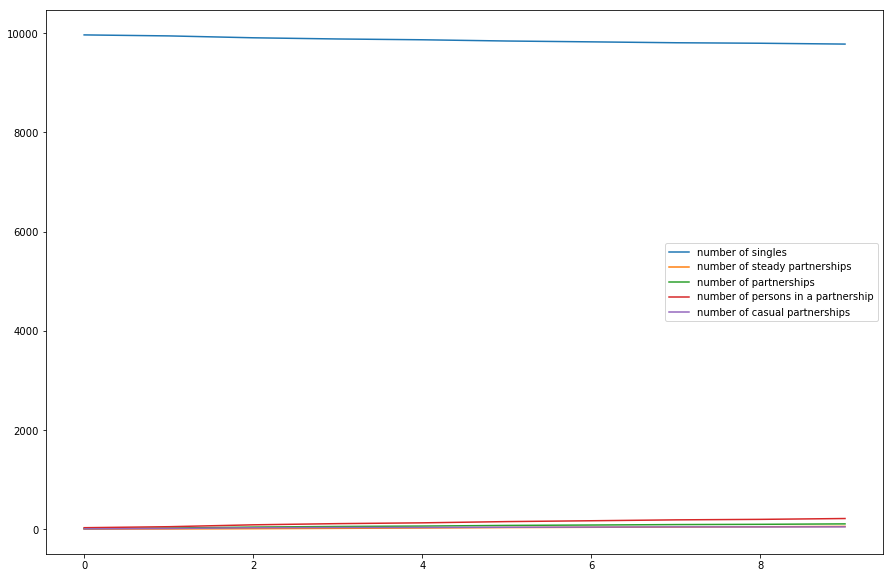

In [75]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(singles_list,label="number of singles")
ax.plot(steady_list,label="number of steady partnerships")
ax.plot(partnerships_list,label="number of partnerships")
ax.plot(len(s.persons)-np.array(singles_list),label="number of persons in a partnership")
ax.plot(np.array(partnerships_list) - np.array(steady_list),label="number of casual partnerships")
ax.legend()